#### Baseline HDC

Python code example that uses your CSV file (from the ISCAS85/EPFL benchmark) without the DGL library. This code assumes that your CSV file (here named "all_circuits_features.csv") already contains the extracted node features (using all the feature columns provided) and a node identifier (in the column "node") plus a categorical gate type (in "gate_type"). We set up the data as follows:

Data Loading and Preprocessing:  Read the CSV with pandas.  Transform the gate type into numerical labels.  Use all given feature columns, drop missing values, convert them to float, and normalize using standard scaling.  (We ignore graph construction since you no longer wish to use DGL; we use only the node features and labels.)

Train-Test Split:  Split the node feature matrix and labels (using an 80/20 split) for classification.

HDC Encoding:  We use a fixed random projection to lift the input features (of dimension =n_features) into a high-dimensional bipolar space (here, with dimensionality HIGH_DIM = 40000).  The projection matrix is created with entries 
±
1
, and the dot product is binarized by taking the sign (=0 becomes 1, otherwise 1).

HDC Node Classification:  For each class (gate label) in the training set, we sum its hypervectors and apply a sign function to create a class prototype.  Classification of a node (sample) is performed by computing the cosine similarity of its hypervector with every prototype and picking the label corresponding to the highest similarity.  We then compute training and testing accuracies and display confusion matrices.

Membership Inference Attack:  For each sample (training and testing), we compute similarity scores between its hypervector and the prototype of its true class, using three metrics:    Cosine similarity    Negative Euclidean distance    Negative Hamming distance  For each metric, we set a threshold (here, as the average training score plus a small delta) and classify a sample as a member if its score exceeds that threshold.  We then print out the fractions of training samples inferred as members (ideally close to 100% if the model remembers its training set) and test samples inferred as non-members.


?? Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60882 entries, 0 to 60881
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   circuit_name            60882 non-null  object 
 1   node                    60882 non-null  object 
 2   gate_type               60882 non-null  object 
 3   fan_in                  60882 non-null  int64  
 4   fan_out                 60882 non-null  int64  
 5   depth                   60882 non-null  object 
 6   dist_to_output          60882 non-null  int64  
 7   is_primary_input        60882 non-null  int64  
 8   is_primary_output       60882 non-null  int64  
 9   is_internal             60882 non-null  int64  
 10  is_key_gate             60882 non-null  int64  
 11  key_dependency          122 non-null    object 
 12  degree_centrality       60882 non-null  float64
 13  betweenness_centrality  60882 non-null  float64
 14  closeness_centra

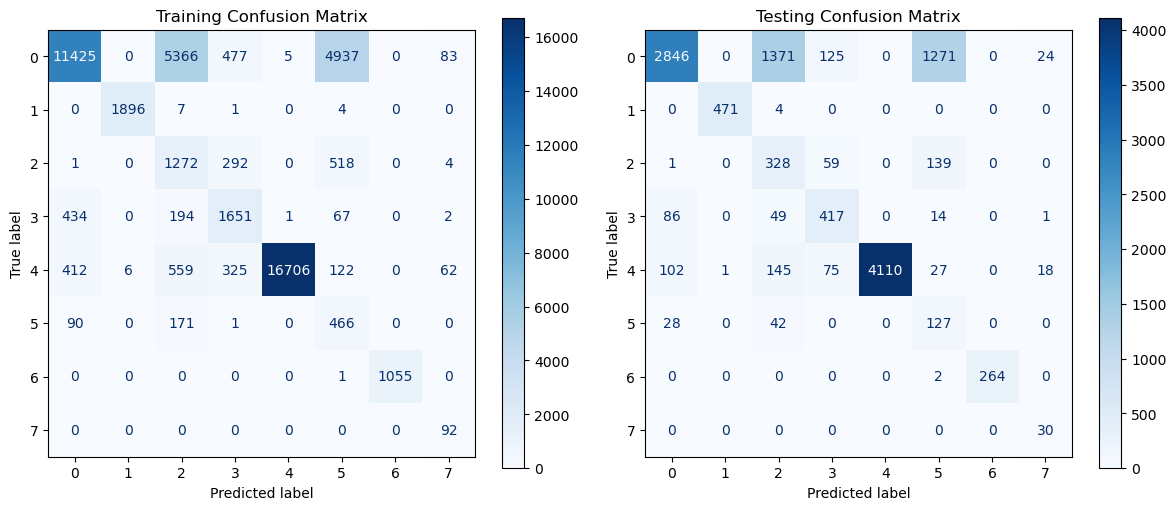


Membership Inference Score Averages (HDC Model):
Cosine Similarity:  Training = 0.4228, Testing = 0.4201
Negative Euclidean: Training = -203.3224, Testing = -203.7649
Negative Hamming:   Training = -0.2886, Testing = -0.2899

Membership Inference Decision Outcomes (Cosine Metric):
  Fraction of Training Samples inferred as members: 0.53
  Fraction of Testing Samples inferred as non-members: 0.47

Membership Inference Decision Outcomes (Euclidean Metric):
  Fraction of Training Samples inferred as members: 0.44
  Fraction of Testing Samples inferred as non-members: 0.56

Membership Inference Decision Outcomes (Hamming Metric):
  Fraction of Training Samples inferred as members: 0.57
  Fraction of Testing Samples inferred as non-members: 0.43


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, hamming
from itertools import combinations

#############################################
# 1. Load and Preprocess the Dataset
#############################################
# Load the dataset from CSV.
df = pd.read_csv("all_circuits_features.csv")

print("\n?? Dataset Overview:")
print(df.info())

# Convert 'gate_type' to numerical labels.
label_encoder = LabelEncoder()
df["gate_label"] = label_encoder.fit_transform(df["gate_type"])

# Define the feature columns as in your reference.
feature_columns = [
    "fan_in", "fan_out", "dist_to_output", "is_primary_input", "is_primary_output",
    "is_internal", "is_key_gate", "degree_centrality", "betweenness_centrality",
    "closeness_centrality", "clustering_coefficient", "avg_fan_in_neighbors", "avg_fan_out_neighbors"
]

# Drop rows that have NaN in any of the feature columns.
df = df.dropna(subset=feature_columns)

# Convert feature columns to float.
df[feature_columns] = df[feature_columns].astype(float)

# Normalize numerical features using StandardScaler.
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Extract features and labels.
features = df[feature_columns].values      # shape: (num_nodes, num_features)
labels = df["gate_label"].values             # shape: (num_nodes,)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

#############################################
# 2. Train-Test Split
#############################################
# Split data into training and testing sets (80%-20% split).
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
print("Training shape:", X_train.shape, "Testing shape:", X_test.shape)

#############################################
# 3. HDC Encoding: Map Raw Features to High-Dimensional Bipolar Hypervectors
#############################################
n_features = X_train.shape[1]  # Should be 13 (the number of feature_columns)
HIGH_DIM = 40000              # Hypervector dimensionality  you can adjust as needed
np.random.seed(42)
# Create fixed random projection matrix (of shape: [n_features, HIGH_DIM]) with entries ±1.
M_proj = np.random.choice([-1, 1], size=(n_features, HIGH_DIM))

def encode_features(features, M):
    """
    Given a 2D numpy array 'features' (num_samples x n_features) and a projection matrix M,
    compute the projected vectors and binarize them using the sign function.
    
    Returns a numpy array of bipolar hypervectors (with values 1 or -1).
    """
    projected = np.dot(features, M)  # shape: (num_samples, HIGH_DIM)
    hvectors = np.where(projected >= 0, 1, -1)
    return hvectors.astype(np.int8)

# Compute hypervectors for train and test samples.
HV_train = encode_features(X_train, M_proj)
HV_test  = encode_features(X_test, M_proj)
print("Encoded Hypervectors shape: Train:", HV_train.shape, "Test:", HV_test.shape)

#############################################
# 4. HDC Model: Train Class Prototypes and Node Classification
#############################################
def train_hdc_model(HV, labels):
    """
    For each class, sum the hypervectors corresponding to that class and
    then threshold the sum (sign function) to create the class prototype.
    """
    prototypes = {}
    labels = np.array(labels)
    for cls in np.unique(labels):
        idx = np.where(labels == cls)[0]
        aggregated = np.sum(HV[idx], axis=0)
        prototypes[int(cls)] = np.where(aggregated >= 0, 1, -1)
    return prototypes

def predict_hdc(HV, prototypes):
    """
    For each sample hypervector in HV, compute cosine similarity with each class prototype.
    Assign the label corresponding to the prototype with the highest cosine similarity.
    """
    preds = []
    for hv in HV:
        sims = {}
        for cls, proto in prototypes.items():
            sim = cosine_similarity(hv.reshape(1, -1), proto.reshape(1, -1))[0][0]
            sims[cls] = sim
        predicted_label = max(sims, key=sims.get)
        preds.append(predicted_label)
    return np.array(preds)

# Train HDC classifier on training nodes.
prototypes = train_hdc_model(HV_train, y_train)

# Perform classification on both training and testing sets.
train_preds = predict_hdc(HV_train, prototypes)
test_preds  = predict_hdc(HV_test, prototypes)

# Compute and display classification accuracies.
train_acc = accuracy_score(y_train, train_preds)
test_acc  = accuracy_score(y_test, test_preds)
print("\nHDC Model Classification Results:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")

#############################################
# 5. Confusion Matrices
#############################################
train_cm = confusion_matrix(y_train, train_preds)
test_cm  = confusion_matrix(y_test, test_preds)
print("\nTraining Confusion Matrix:")
print(train_cm)
print("\nTesting Confusion Matrix:")
print(test_cm)

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=np.unique(y_train))
disp_train.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Training Confusion Matrix")
plt.subplot(1,2,2)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=np.unique(y_test))
disp_test.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Testing Confusion Matrix")
plt.tight_layout()
plt.show()

#############################################
# 6. Membership Inference Attack Using Three Metrics
#############################################
def evaluate_membership(HV, labels, prototypes, metric="cosine"):
    """
    Compute for each sample a similarity (or negated distance) score between its hypervector
    and the prototype of its true class using the chosen metric:
       - "cosine": cosine similarity,
       - "euclidean": negative Euclidean distance,
       - "hamming": negative Hamming distance.
    Returns an array of scores (one per sample).
    """
    labels = np.array(labels)
    scores = []
    for i, hv in enumerate(HV):
        cls = int(labels[i])
        proto = prototypes[cls]
        if metric == "cosine":
            score = cosine_similarity(hv.reshape(1, -1), proto.reshape(1, -1))[0][0]
        elif metric == "euclidean":
            score = -euclidean(hv, proto)
        elif metric == "hamming":
            score = -hamming(hv, proto)
        else:
            raise ValueError("Unsupported metric")
        scores.append(score)
    return np.array(scores)

def membership_inference(scores, threshold):
    """
    Given a vector of membership scores, classify a sample as a "member" if its score exceeds the threshold.
    """
    return scores > threshold

# Compute membership inference scores for each metric.
train_score_cos = evaluate_membership(HV_train, y_train, prototypes, metric="cosine")
test_score_cos  = evaluate_membership(HV_test, y_test, prototypes, metric="cosine")
train_score_euc = evaluate_membership(HV_train, y_train, prototypes, metric="euclidean")
test_score_euc  = evaluate_membership(HV_test, y_test, prototypes, metric="euclidean")
train_score_ham = evaluate_membership(HV_train, y_train, prototypes, metric="hamming")
test_score_ham  = evaluate_membership(HV_test, y_test, prototypes, metric="hamming")

print("\nMembership Inference Score Averages (HDC Model):")
print(f"Cosine Similarity:  Training = {np.mean(train_score_cos):.4f}, Testing = {np.mean(test_score_cos):.4f}")
print(f"Negative Euclidean: Training = {np.mean(train_score_euc):.4f}, Testing = {np.mean(test_score_euc):.4f}")
print(f"Negative Hamming:   Training = {np.mean(train_score_ham):.4f}, Testing = {np.mean(test_score_ham):.4f}")

# Set thresholds as the average training score + delta (adjust deltas if needed)
delta_cos = 0.02
delta_euc = 0.0    # Adjust as needed.
delta_ham = 0.0    # Adjust as needed.
thr_cos = np.mean(train_score_cos) + delta_cos
thr_euc = np.mean(train_score_euc) + delta_euc
thr_ham = np.mean(train_score_ham) + delta_ham

# Infer membership decisions using each metric.
train_membership_cos = membership_inference(train_score_cos, thr_cos)
test_membership_cos  = membership_inference(test_score_cos, thr_cos)
train_membership_euc = membership_inference(train_score_euc, thr_euc)
test_membership_euc  = membership_inference(test_score_euc, thr_euc)
train_membership_ham = membership_inference(train_score_ham, thr_ham)
test_membership_ham  = membership_inference(test_score_ham, thr_ham)

print("\nMembership Inference Decision Outcomes (Cosine Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_cos):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_cos):.2f}")

print("\nMembership Inference Decision Outcomes (Euclidean Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_euc):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_euc):.2f}")

print("\nMembership Inference Decision Outcomes (Hamming Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_ham):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_ham):.2f}")


#### Iterative Retraining and Regenerative Training

In this version, we add an iterative retraining (regenerative training) step to refine class prototypes. Specifically, after obtaining the initial hypervectors (via a fixed random projection), we initialize a weight vector (all ones) for the training samples. Then, over several iterations, we compute weighted class prototypes, predict on the training set, and for every misclassified sample, we boost its weight by a factor a. Finally, we use the resulting (refined) prototypes for classification on both training and test sets, display the confusion matrices, and compute membership inference scores via three metrics (cosine, negative Euclidean, and negative Hamming).

Dataset Preparation (Part A): The code loads the CSV file (assumed to be named "all_circuits_features.csv"), converts the gate_type column to numerical labels, selects the 13 numerical features, excludes rows with missing values, converts the features to floats, and normalizes them. (We ignore the graph construction here because the HDC model uses only the node feature matrix and labels.)

Train-Test Split (Part B): The node feature matrix and associated labels are split into training and test sets.

HDC Encoding (Part C): A fixed random projection matrix 
??
proj
 (with dimensions [n_features, HIGH_DIM]) is generated to lift each nodes feature vector into a 40,000-dimensional bipolar space (after taking the sign). These hypervectors represent the nodes.

Iterative Retraining  Regenerative Training (Part D): Instead of computing static class prototypes, we iteratively refine them. We initialize a per-sample weight vector (ones) and, over a few iterations, compute weighted prototypes for each class. After each iteration, predictions are computed on the training set and the weights of misclassified samples are boosted by multiplying by a. This regenerative update helps adapt the prototypes to challenging cases.

Classification and Evaluation: After iterative retraining, the final prototypes are used to classify both training and testing nodes. Accuracies are computed and confusion matrices are plotted.

Membership Inference (Part F): For each node, membership inference scores are computed by comparing the nodes hypervector to the true class prototype using three metrics: cosine similarity, negative Euclidean distance, and negative Hamming distance. For each metric, a threshold is set (average training score + small delta) and used to infer membership. Finally, the fractions (e.g. training samples inferred as members and test samples as non-members) are printed.


?? Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60882 entries, 0 to 60881
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   circuit_name            60882 non-null  object 
 1   node                    60882 non-null  object 
 2   gate_type               60882 non-null  object 
 3   fan_in                  60882 non-null  int64  
 4   fan_out                 60882 non-null  int64  
 5   depth                   60882 non-null  object 
 6   dist_to_output          60882 non-null  int64  
 7   is_primary_input        60882 non-null  int64  
 8   is_primary_output       60882 non-null  int64  
 9   is_internal             60882 non-null  int64  
 10  is_key_gate             60882 non-null  int64  
 11  key_dependency          122 non-null    object 
 12  degree_centrality       60882 non-null  float64
 13  betweenness_centrality  60882 non-null  float64
 14  closeness_centra

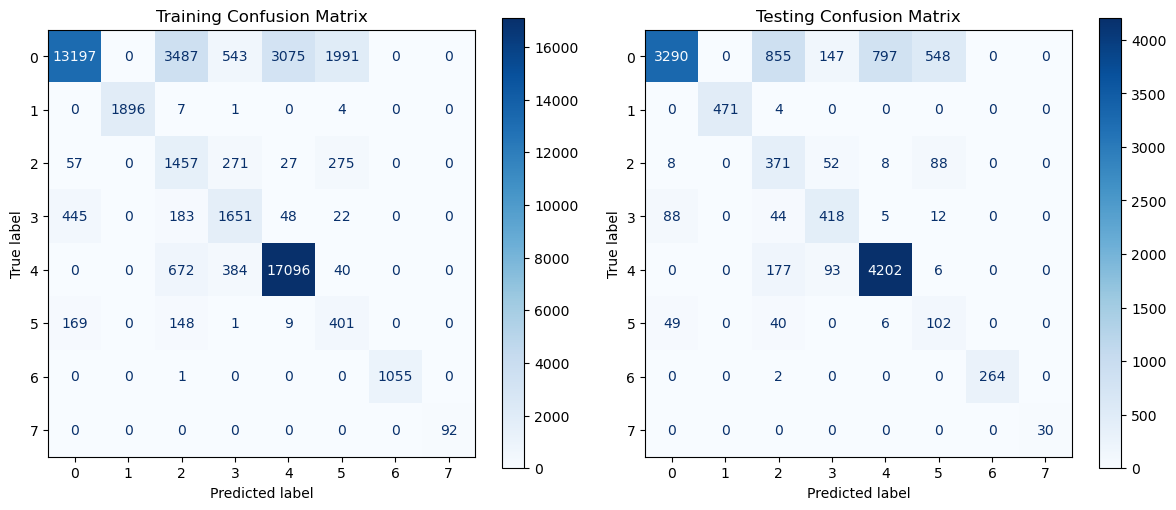


Membership Inference Score Averages (HDC Model):
  Cosine Similarity:  Training = 0.4111, Testing = 0.4088
  Negative Euclidean: Training = -207.4076, Testing = -207.7852
  Negative Hamming:   Training = -0.2945, Testing = -0.2956

Membership Inference Decision Outcomes (Cosine Metric):
  Fraction of Training Samples inferred as members: 0.50
  Fraction of Testing Samples inferred as non-members: 0.50

Membership Inference Decision Outcomes (Euclidean Metric):
  Fraction of Training Samples inferred as members: 0.42
  Fraction of Testing Samples inferred as non-members: 0.59

Membership Inference Decision Outcomes (Hamming Metric):
  Fraction of Training Samples inferred as members: 0.55
  Fraction of Testing Samples inferred as non-members: 0.45


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, hamming
from itertools import combinations

#############################################
# Part A: Load and Preprocess the Dataset
#############################################
# Load the dataset from CSV.
df = pd.read_csv("all_circuits_features.csv")

print("\n?? Dataset Overview:")
print(df.info())

# Convert 'gate_type' to numerical labels.
label_encoder = LabelEncoder()
df["gate_label"] = label_encoder.fit_transform(df["gate_type"])

# Use all the feature columns as given.
feature_columns = [
    "fan_in", "fan_out", "dist_to_output", "is_primary_input", "is_primary_output",
    "is_internal", "is_key_gate", "degree_centrality", "betweenness_centrality",
    "closeness_centrality", "clustering_coefficient", "avg_fan_in_neighbors", "avg_fan_out_neighbors"
]

# Drop rows with missing values in the feature columns.
df = df.dropna(subset=feature_columns)

# Convert feature columns to float.
df[feature_columns] = df[feature_columns].astype(float)

# Normalize numerical features using StandardScaler.
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Extract features and labels.
features = df[feature_columns].values   # shape: (num_nodes, num_features)
labels = df["gate_label"].values          # shape: (num_nodes,)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

#############################################
# Part B: Train-Test Split
#############################################
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
print("\nTraining shape:", X_train.shape, "| Testing shape:", X_test.shape)

#############################################
# Part C: HDC Encoding  Map Features to High-Dimensional Bipolar Hypervectors
#############################################
n_features = X_train.shape[1]       # e.g., 13
HIGH_DIM = 40000                    # Adjust as needed
np.random.seed(42)
# Fixed random projection matrix of shape (n_features, HIGH_DIM) with entries ±1.
M_proj = np.random.choice([-1, 1], size=(n_features, HIGH_DIM))

def encode_features(features, M):
    """
    Projects the feature matrix (num_samples x n_features) using the projection matrix M,
    and then binarizes the result by taking the sign (=0 ? 1, else -1).
    Returns a numpy array of bipolar hypervectors.
    """
    projected = np.dot(features, M)
    hvectors = np.where(projected >= 0, 1, -1)
    return hvectors.astype(np.int8)

HV_train = encode_features(X_train, M_proj)
HV_test  = encode_features(X_test, M_proj)
print("\nEncoded Hypervectors shape: ")
print("  Training:", HV_train.shape, " | Testing:", HV_test.shape)

#############################################
# Part D: HDC Model with Iterative Retraining (Regenerative Training)
#############################################
def predict_hdc(HV, prototypes):
    """
    For each sample hypervector in HV, compute cosine similarity with each class prototype.
    Return the predicted label corresponding to the highest similarity.
    """
    preds = []
    for hv in HV:
        sim_scores = {}
        for cls, proto in prototypes.items():
            sim = cosine_similarity(hv.reshape(1, -1), proto.reshape(1, -1))[0][0]
            sim_scores[cls] = sim
        predicted = max(sim_scores, key=sim_scores.get)
        preds.append(predicted)
    return np.array(preds)

def iterative_retraining(HV, labels, num_iter=3, alpha=2.0):
    """
    Iteratively refine class prototypes. For each iteration:
      - Compute weighted class prototypes (by summing hypervectors multiplied by per-sample weights).
      - Use these prototypes to predict labels on the training set.
      - If an instance is misclassified, boost its weight by multiplying by alpha.
    Bookmarks the prototypes at the iteration with the highest training accuracy.
    
    Returns best_prototypes (the prototypes from the best iteration) and best_acc.
    """
    labels = np.array(labels)
    N = len(labels)
    weights = np.ones(N)
    best_acc = 0.0
    best_prototypes = None
    for it in range(num_iter):
        prototypes = {}
        for cls in np.unique(labels):
            idx = np.where(labels == cls)[0]
            aggregated = np.sum(weights[idx][:, np.newaxis] * HV[idx], axis=0)
            prototypes[int(cls)] = np.where(aggregated >= 0, 1, -1)
        # Predict on the training set with the current prototypes.
        train_preds_iter = predict_hdc(HV, prototypes)
        acc = accuracy_score(labels, train_preds_iter)
        print(f"Iteration {it+1}: Training Accuracy = {acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            # Make a deep copy of the prototypes.
            best_prototypes = {cls: prototypes[cls].copy() for cls in prototypes}
        # Boost weights for misclassified samples.
        for i in range(N):
            if train_preds_iter[i] != labels[i]:
                weights[i] *= alpha
    return best_prototypes, best_acc

NUM_ITER = 3
ALPHA = 2.0
prototypes, best_iter_acc = iterative_retraining(HV_train, y_train, num_iter=NUM_ITER, alpha=ALPHA)
print(f"\nSelected Prototypes from Best Iteration with Training Accuracy = {best_iter_acc:.4f}")

# Use the bookmarked prototypes for final classification.
train_preds = predict_hdc(HV_train, prototypes)
test_preds  = predict_hdc(HV_test, prototypes)
train_acc = accuracy_score(y_train, train_preds)
test_acc  = accuracy_score(y_test, test_preds)
print("\nFinal HDC Model Classification Results (with Iterative Retraining):")
print(f"  Training Accuracy: {train_acc:.4f}")
print(f"  Testing Accuracy:  {test_acc:.4f}")

#############################################
# Part E: Display Confusion Matrices
#############################################
train_cm = confusion_matrix(y_train, train_preds)
test_cm = confusion_matrix(y_test, test_preds)
print("\nTraining Confusion Matrix:")
print(train_cm)
print("\nTesting Confusion Matrix:")
print(test_cm)

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=np.unique(y_train))
disp_train.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Training Confusion Matrix")
plt.subplot(1,2,2)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=np.unique(y_test))
disp_test.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Testing Confusion Matrix")
plt.tight_layout()
plt.show()

#############################################
# Part F: Membership Inference Attack Using Three Metrics
#############################################
def evaluate_membership(HV, labels, prototypes, metric="cosine"):
    """
    For each sample, compute a score by comparing its hypervector to the prototype of its true class.
      - For metric "cosine": use cosine similarity.
      - For metric "euclidean": compute Euclidean distance and take negative.
      - For metric "hamming": compute Hamming distance and take negative.
    Returns an array of scores.
    """
    labels = np.array(labels)
    scores = []
    for i, hv in enumerate(HV):
        cls = int(labels[i])
        proto = prototypes[cls]
        if metric == "cosine":
            score = cosine_similarity(hv.reshape(1, -1), proto.reshape(1, -1))[0][0]
        elif metric == "euclidean":
            score = -euclidean(hv, proto)
        elif metric == "hamming":
            score = -hamming(hv, proto)
        else:
            raise ValueError("Unsupported metric")
        scores.append(score)
    return np.array(scores)

def membership_inference(scores, threshold):
    """
    Classify a sample as a training member if its score exceeds the threshold.
    """
    return scores > threshold

# Compute membership inference scores for training and testing samples.
train_score_cos = evaluate_membership(HV_train, y_train, prototypes, metric="cosine")
test_score_cos  = evaluate_membership(HV_test, y_test, prototypes, metric="cosine")
train_score_euc = evaluate_membership(HV_train, y_train, prototypes, metric="euclidean")
test_score_euc  = evaluate_membership(HV_test, y_test, prototypes, metric="euclidean")
train_score_ham = evaluate_membership(HV_train, y_train, prototypes, metric="hamming")
test_score_ham  = evaluate_membership(HV_test, y_test, prototypes, metric="hamming")

print("\nMembership Inference Score Averages (HDC Model):")
print(f"  Cosine Similarity:  Training = {np.mean(train_score_cos):.4f}, Testing = {np.mean(test_score_cos):.4f}")
print(f"  Negative Euclidean: Training = {np.mean(train_score_euc):.4f}, Testing = {np.mean(test_score_euc):.4f}")
print(f"  Negative Hamming:   Training = {np.mean(train_score_ham):.4f}, Testing = {np.mean(test_score_ham):.4f}")

# Set thresholds for membership inferencethresholds set as average training score plus delta.
delta_cos = 0.02
delta_euc = 0.0    # Adjust as needed.
delta_ham = 0.0    # Adjust as needed.
thr_cos = np.mean(train_score_cos) + delta_cos
thr_euc = np.mean(train_score_euc) + delta_euc
thr_ham = np.mean(train_score_ham) + delta_ham

# Infer membership decisions.
train_membership_cos = membership_inference(train_score_cos, thr_cos)
test_membership_cos  = membership_inference(test_score_cos, thr_cos)
train_membership_euc = membership_inference(train_score_euc, thr_euc)
test_membership_euc  = membership_inference(test_score_euc, thr_euc)
train_membership_ham = membership_inference(train_score_ham, thr_ham)
test_membership_ham  = membership_inference(test_score_ham, thr_ham)

print("\nMembership Inference Decision Outcomes (Cosine Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_cos):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_cos):.2f}")

print("\nMembership Inference Decision Outcomes (Euclidean Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_euc):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_euc):.2f}")

print("\nMembership Inference Decision Outcomes (Hamming Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_ham):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_ham):.2f}")


#### Adaptive Encoding 

In this approach the raw node features are first preprocessed by PCA so that the most informative components are retained. Those PCA-transformed features are then lifted into a high-dimensional bipolar space using a fixed (but now data-driven) projection matrix. The HDC model is built by aggregating the training hypervectors into class prototypes. Node classification is performed by assigning a new (test or training) sample the label of the prototype that maximizes cosine similarity. Finally, confusion matrices are displayed and three membership inference metricscosine similarity, negative Euclidean distance, and negative Hamming distanceare computed (using thresholds set from the training scores).

Dataset Preparation (Parts AB): The code loads the CSV file, converts gate_type to numerical labels, selects the 13 feature columns (dropping missing values), standardizes them, and splits the dataset into training and testing sets.

Adaptive Encoding (Part C): Instead of using raw (normalized) features for random projection, we first apply PCA to reduce the dimensionality (from 13 to 8 components, here) so that the most informative, data-driven features are emphasized. A new projection matrix is generated for the PCA-transformed data, and the resulting dot product is binarized (using the sign) to form the high-dimensional bipolar hypervectors.

HDC Node Classification (Part DE): Class prototypes are computed by summing the training hypervectors by class and thresholding. Node classification uses cosine similarity between a nodes hypervector and each prototype. Overall training and testing accuracies are computed and confusion matrices are displayed.

Membership Inference (Part F): Three separate metrics (cosine similarity, negative Euclidean distance, and negative Hamming distance) are used to compute a membership score for each node by comparing its hypervector with its true-class prototype. Thresholds for membership inference are set as the average training score plus a small delta. Finally, the fraction of training nodes inferred as members and testing nodes inferred as non-members is printed.


?? Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60882 entries, 0 to 60881
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   circuit_name            60882 non-null  object 
 1   node                    60882 non-null  object 
 2   gate_type               60882 non-null  object 
 3   fan_in                  60882 non-null  int64  
 4   fan_out                 60882 non-null  int64  
 5   depth                   60882 non-null  object 
 6   dist_to_output          60882 non-null  int64  
 7   is_primary_input        60882 non-null  int64  
 8   is_primary_output       60882 non-null  int64  
 9   is_internal             60882 non-null  int64  
 10  is_key_gate             60882 non-null  int64  
 11  key_dependency          122 non-null    object 
 12  degree_centrality       60882 non-null  float64
 13  betweenness_centrality  60882 non-null  float64
 14  closeness_centra

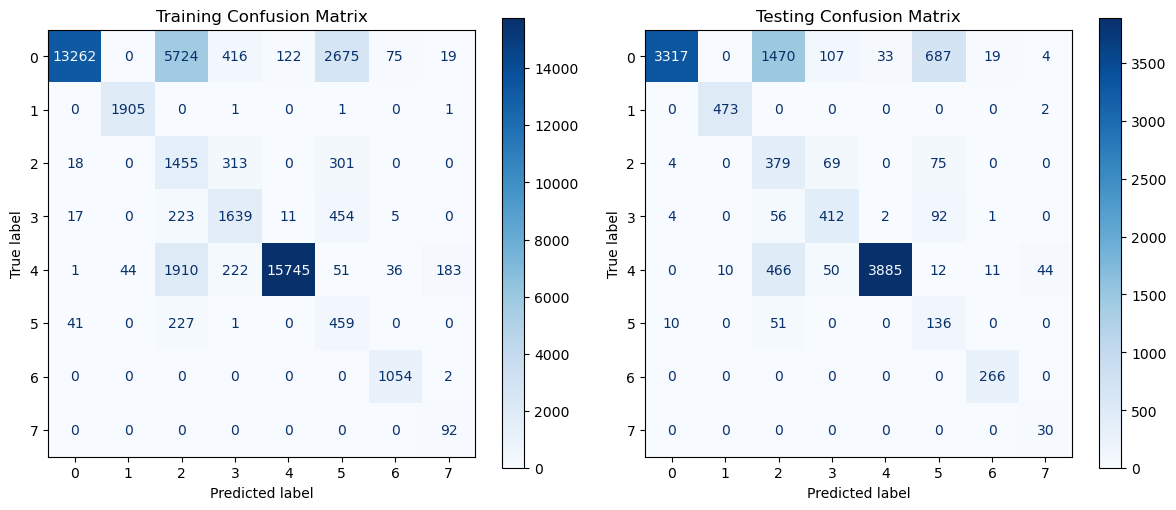


Membership Inference Score Averages (Adaptive Encoding HDC Model):
  Cosine Similarity:  Training = 0.4861, Testing = 0.4829
  Negative Euclidean: Training = -190.4518, Testing = -191.1613
  Negative Hamming:   Training = -0.2570, Testing = -0.2585

Membership Inference Decision Outcomes (Cosine Metric):
  Fraction of Training Samples inferred as members: 0.57
  Fraction of Testing Samples inferred as non-members: 0.44

Membership Inference Decision Outcomes (Euclidean Metric):
  Fraction of Training Samples inferred as members: 0.49
  Fraction of Testing Samples inferred as non-members: 0.51

Membership Inference Decision Outcomes (Hamming Metric):
  Fraction of Training Samples inferred as members: 0.59
  Fraction of Testing Samples inferred as non-members: 0.42


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, hamming
from itertools import combinations

#############################################
# Part A: Load and Preprocess the Dataset
#############################################
# Load dataset from CSV
df = pd.read_csv("all_circuits_features.csv")

print("\n?? Dataset Overview:")
print(df.info())

# Convert 'gate_type' to numerical labels.
label_encoder = LabelEncoder()
df["gate_label"] = label_encoder.fit_transform(df["gate_type"])

# Use all feature columns as given.
feature_columns = [
    "fan_in", "fan_out", "dist_to_output", "is_primary_input", "is_primary_output",
    "is_internal", "is_key_gate", "degree_centrality", "betweenness_centrality",
    "closeness_centrality", "clustering_coefficient", "avg_fan_in_neighbors", "avg_fan_out_neighbors"
]

# Drop rows with missing values in the feature columns.
df = df.dropna(subset=feature_columns)

# Convert feature columns to float.
df[feature_columns] = df[feature_columns].astype(float)

# Normalize features using StandardScaler.
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Extract features and labels.
features = df[feature_columns].values   # shape: (num_nodes, num_features)
labels = df["gate_label"].values          # shape: (num_nodes,)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

#############################################
# Part B: Train-Test Split
#############################################
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
print("\nTraining shape:", X_train.shape, "| Testing shape:", X_test.shape)

#############################################
# Part C: Adaptive Encoding using PCA Preprocessing
#############################################
# Instead of a random projection on raw features, we first reduce the dimensionality
# using PCA so that the most informative features are emphasized.
n_components_pca = 8   # For example, reduce from 13 features to 8 principal components. Adjust as needed.
pca_model = PCA(n_components=n_components_pca)
X_train_pca = pca_model.fit_transform(X_train)
X_test_pca  = pca_model.transform(X_test)
print("\nPCA-transformed Training shape:", X_train_pca.shape)
print("PCA-transformed Testing shape:", X_test_pca.shape)

# Now, we lift these PCA features into a high-dimensional (HD) space.
HIGH_DIM = 40000  # Hypervector dimensionality  adjust as needed.
np.random.seed(42)
# Create a fixed (but now lower-dimensional input) projection matrix of shape (n_components_pca, HIGH_DIM).
M_proj = np.random.choice([-1, 1], size=(n_components_pca, HIGH_DIM))

def encode_features(features, M):
    """
    Given a feature matrix 'features' (num_samples x n_components_pca) and
    projection matrix M, compute the dot product then binarize the result
    via the sign function (=0 becomes 1 and <0 becomes -1).
    Returns a numpy array of bipolar hypervectors.
    """
    projected = np.dot(features, M)  # shape: (num_samples, HIGH_DIM)
    hvectors = np.where(projected >= 0, 1, -1)
    return hvectors.astype(np.int8)

# Encode training and testing samples using the PCA-transformed features.
HV_train = encode_features(X_train_pca, M_proj)
HV_test  = encode_features(X_test_pca, M_proj)
print("\nEncoded Hypervectors shape:")
print("  Training:", HV_train.shape, "| Testing:", HV_test.shape)

#############################################
# Part D: HDC Model  Class Prototype Formation and Node Classification
#############################################
def train_hdc_model(HV, labels):
    """
    For each unique class in 'labels', sum the hypervectors for that class
    (from the training set) and then threshold (using sign) to form a class prototype.
    """
    prototypes = {}
    labels = np.array(labels)
    for cls in np.unique(labels):
        idx = np.where(labels == cls)[0]
        aggregated = np.sum(HV[idx], axis=0)
        prototypes[int(cls)] = np.where(aggregated >= 0, 1, -1)
    return prototypes

def predict_hdc(HV, prototypes):
    """
    For each sample hypervector in HV, compute its cosine similarity with each class prototype.
    The predicted label is the one corresponding to the highest similarity.
    """
    preds = []
    for hv in HV:
        sim_scores = {}
        for cls, proto in prototypes.items():
            sim = cosine_similarity(hv.reshape(1, -1), proto.reshape(1, -1))[0][0]
            sim_scores[cls] = sim
        predicted = max(sim_scores, key=sim_scores.get)
        preds.append(predicted)
    return np.array(preds)

# (If desired, one could add iterative retraining herebut for the adaptive encoding technique,
# we keep the process standard.)
prototypes = train_hdc_model(HV_train, y_train)

# Classify training and testing samples.
train_preds = predict_hdc(HV_train, prototypes)
test_preds  = predict_hdc(HV_test, prototypes)

# Compute and print classification accuracies.
train_acc = accuracy_score(y_train, train_preds)
test_acc  = accuracy_score(y_test, test_preds)
print("\nHDC Model Classification Results (Adaptive Encoding):")
print(f"  Training Accuracy: {train_acc:.4f}")
print(f"  Testing Accuracy:  {test_acc:.4f}")

#############################################
# Part E: Display Confusion Matrices
#############################################
train_cm = confusion_matrix(y_train, train_preds)
test_cm  = confusion_matrix(y_test, test_preds)
print("\nTraining Confusion Matrix:")
print(train_cm)
print("\nTesting Confusion Matrix:")
print(test_cm)

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=np.unique(y_train))
disp_train.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Training Confusion Matrix")

plt.subplot(1,2,2)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=np.unique(y_test))
disp_test.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Testing Confusion Matrix")
plt.tight_layout()
plt.show()

#############################################
# Part F: Membership Inference Attack Using Three Metrics
#############################################
def evaluate_membership(HV, labels, prototypes, metric="cosine"):
    """
    For each sample hypervector, compute a membership score by comparing it to the prototype
    of its true class using the specified metric:
      - "cosine": cosine similarity.
      - "euclidean": negative Euclidean distance.
      - "hamming": negative Hamming distance.
    Returns an array of scores.
    """
    labels = np.array(labels)
    scores = []
    for i, hv in enumerate(HV):
        cls = int(labels[i])
        proto = prototypes[cls]
        if metric == "cosine":
            score = cosine_similarity(hv.reshape(1, -1), proto.reshape(1, -1))[0][0]
        elif metric == "euclidean":
            score = -euclidean(hv, proto)
        elif metric == "hamming":
            score = -hamming(hv, proto)
        else:
            raise ValueError("Unsupported metric")
        scores.append(score)
    return np.array(scores)

def membership_inference(scores, threshold):
    """
    Infer membership from scores by classifying a sample as a member if its score exceeds the threshold.
    """
    return scores > threshold

# Compute membership inference scores on training and testing hypervectors.
train_score_cos = evaluate_membership(HV_train, y_train, prototypes, metric="cosine")
test_score_cos  = evaluate_membership(HV_test, y_test, prototypes, metric="cosine")
train_score_euc = evaluate_membership(HV_train, y_train, prototypes, metric="euclidean")
test_score_euc  = evaluate_membership(HV_test, y_test, prototypes, metric="euclidean")
train_score_ham = evaluate_membership(HV_train, y_train, prototypes, metric="hamming")
test_score_ham  = evaluate_membership(HV_test, y_test, prototypes, metric="hamming")

print("\nMembership Inference Score Averages (Adaptive Encoding HDC Model):")
print(f"  Cosine Similarity:  Training = {np.mean(train_score_cos):.4f}, Testing = {np.mean(test_score_cos):.4f}")
print(f"  Negative Euclidean: Training = {np.mean(train_score_euc):.4f}, Testing = {np.mean(test_score_euc):.4f}")
print(f"  Negative Hamming:   Training = {np.mean(train_score_ham):.4f}, Testing = {np.mean(test_score_ham):.4f}")

# Set thresholds as the average training score plus a small delta.
delta_cos = 0.02  # Adjust if needed.
delta_euc = 0.0   # Adjust if needed.
delta_ham = 0.0   # Adjust if needed.
thr_cos = np.mean(train_score_cos) + delta_cos
thr_euc = np.mean(train_score_euc) + delta_euc
thr_ham = np.mean(train_score_ham) + delta_ham

# Infer membership decisions.
train_membership_cos = membership_inference(train_score_cos, thr_cos)
test_membership_cos  = membership_inference(test_score_cos, thr_cos)
train_membership_euc = membership_inference(train_score_euc, thr_euc)
test_membership_euc  = membership_inference(test_score_euc, thr_euc)
train_membership_ham = membership_inference(train_score_ham, thr_ham)
test_membership_ham  = membership_inference(test_score_ham, thr_ham)

print("\nMembership Inference Decision Outcomes (Cosine Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_cos):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_cos):.2f}")

print("\nMembership Inference Decision Outcomes (Euclidean Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_euc):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_euc):.2f}")

print("\nMembership Inference Decision Outcomes (Hamming Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_ham):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_ham):.2f}")


#### Hybrid HDC model

In this approach, we first train a lightweight neural network (using PyTorch) on the normalized node features from your CSV (all_circuits_features.csv). The network is used as a feature extractor. Its penultimate layer output (a learned low-dimensional representation) is then lifted by a data-driven random projection into a high-dimensional bipolar space. Finally, we build an HDC model (by forming class prototypes via summing and binarization) that classifies nodes (using cosine similarity). The code then displays the confusion matrices and computes membership inference scores using three metrics (cosine, negative Euclidean, and negative Hamming), along with threshold-based membership decisions.

Dataset Preparation (Parts AB): The code loads your CSV file, converts the categorical gate type to numerical labels, extracts the 13 feature columns, drops rows with missing values, standardizes the features, and splits them into training and testing sets.

Hybrid Feature Extraction (Part C): A lightweight neural network (implemented in PyTorch) is trained to extract a learned low-dimensional representation (here of dimension 16) from the raw 13 features. After training, the networks feature extractor is used to transform the training and test data into new features.

HDC Encoding (Part D): These neural networkextracted features are lifted into a high-dimensional bipolar space via a fixed random projection (from dimension 16 to 40000). (You can adjust these values as needed.) Then, class prototypes are computed by aggregating the training hypervectors per class and binarizing the sum. Node classification is performed by comparing (via cosine similarity) each hypervector to each prototype. The training and testing accuracies are computed and displayed.

Confusion Matrices (Part E): Confusion matrices for training and test predictions are displayed.

Membership Inference (Part F): Using three metrics (cosine similarity, negative Euclidean, and negative Hamming), a membership score is computed for each sample by comparing its hypervector to the prototype of its true class. Thresholds (equal to the average training score plus a small delta) are set, and membership decisions are inferred. Finally, the code prints the fraction of training samples inferred as members and testing samples as non-members.


?? Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60882 entries, 0 to 60881
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   circuit_name            60882 non-null  object 
 1   node                    60882 non-null  object 
 2   gate_type               60882 non-null  object 
 3   fan_in                  60882 non-null  int64  
 4   fan_out                 60882 non-null  int64  
 5   depth                   60882 non-null  object 
 6   dist_to_output          60882 non-null  int64  
 7   is_primary_input        60882 non-null  int64  
 8   is_primary_output       60882 non-null  int64  
 9   is_internal             60882 non-null  int64  
 10  is_key_gate             60882 non-null  int64  
 11  key_dependency          122 non-null    object 
 12  degree_centrality       60882 non-null  float64
 13  betweenness_centrality  60882 non-null  float64
 14  closeness_centra

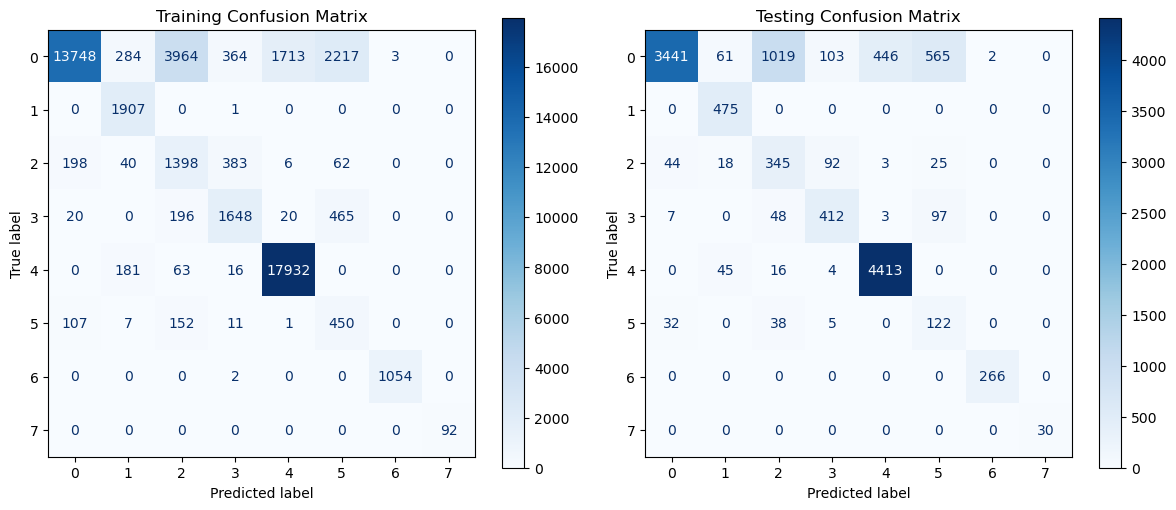


Membership Inference Score Averages (Hybrid HDC Model):
  Cosine Similarity:  Training = 0.8801, Testing = 0.8788
  Negative Euclidean: Training = -75.2945, Testing = -75.9475
  Negative Hamming:   Training = -0.0599, Testing = -0.0606

Membership Inference Decision Outcomes (Cosine Metric):
  Fraction of Training Samples inferred as members: 0.67
  Fraction of Testing Samples inferred as non-members: 0.33

Membership Inference Decision Outcomes (Euclidean Metric):
  Fraction of Training Samples inferred as members: 0.56
  Fraction of Testing Samples inferred as non-members: 0.44

Membership Inference Decision Outcomes (Hamming Metric):
  Fraction of Training Samples inferred as members: 0.73
  Fraction of Testing Samples inferred as non-members: 0.28


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, hamming

import torch
import torch.nn as nn
import torch.optim as optim

#############################################
# Part A: Load and Preprocess the Dataset
#############################################
df = pd.read_csv("all_circuits_features.csv")

print("\n?? Dataset Overview:")
print(df.info())

# Convert 'gate_type' to numerical labels.
label_encoder = LabelEncoder()
df["gate_label"] = label_encoder.fit_transform(df["gate_type"])

# Define feature columns (exactly as provided).
feature_columns = [
    "fan_in", "fan_out", "dist_to_output", "is_primary_input", "is_primary_output",
    "is_internal", "is_key_gate", "degree_centrality", "betweenness_centrality",
    "closeness_centrality", "clustering_coefficient", "avg_fan_in_neighbors", "avg_fan_out_neighbors"
]

# Drop rows with missing values.
df = df.dropna(subset=feature_columns)

# Convert features to float.
df[feature_columns] = df[feature_columns].astype(float)

# Normalize features.
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Extract features and labels.
features = df[feature_columns].values    # shape: (num_nodes, num_features)
labels = df["gate_label"].values           # shape: (num_nodes,)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

#############################################
# Part B: Train-Test Split
#############################################
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
print("\nTraining shape:", X_train.shape, "| Testing shape:", X_test.shape)

#############################################
# Part C: Hybrid Feature Extraction Using a Neural Network
#############################################
# We define a lightweight neural network that learns to extract features from the 13 input features.
# The network consists of a feature extractor (two linear layers with ReLU)
# and a final classification layer. We train the model on the training data.
# After training, we discard the final classifier and use the feature extractor's output.

class HybridNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, feature_dim, num_classes):
        super(HybridNet, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, feature_dim),
            nn.ReLU()
        )
        self.classifier = nn.Linear(feature_dim, num_classes)
    
    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits, features

# Set hyperparameters for the neural network.
input_dim = X_train.shape[1]            # 13
hidden_dim = 32
feature_dim = 16                        # Learned representation dimensionality
num_classes = len(np.unique(y_train))     # Number of gate classes

# Convert training and test data to torch tensors.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_t  = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test, dtype=torch.long).to(device)

# Instantiate the model.
model = HybridNet(input_dim, hidden_dim, feature_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the network (for a modest number of epochs).
num_epochs = 20
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    logits, _ = model(X_train_t)
    loss = criterion(logits, y_train_t)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 == 0:
        _, predicted = torch.max(logits, 1)
        acc = (predicted == y_train_t).float().mean().item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {acc:.4f}")

# After training, switch to evaluation mode.
model.eval()
with torch.no_grad():
    _, features_train_nn = model(X_train_t)   # shape: (num_train, feature_dim)
    _, features_test_nn = model(X_test_t)       # shape: (num_test, feature_dim)

# Convert extracted features to numpy arrays.
features_train_nn = features_train_nn.cpu().numpy()
features_test_nn = features_test_nn.cpu().numpy()
print("\nExtracted Neural Network Feature shape (Train):", features_train_nn.shape)
print("Extracted Neural Network Feature shape (Test):", features_test_nn.shape)

#############################################
# Part D: HDC Encoding  Lift Neural Network Features into High-Dimensional Space
#############################################
# Use the NN-extracted features (dimension = feature_dim) as input to HDC.
n_extracted_features = features_train_nn.shape[1]  # should equal feature_dim (e.g., 16)
HIGH_DIM = 40000  # Hypervector dimensionality - adjust as needed.
np.random.seed(42)
# Create a fixed random projection matrix M of shape (n_extracted_features, HIGH_DIM) with ±1 entries.
M_proj = np.random.choice([-1, 1], size=(n_extracted_features, HIGH_DIM))

def encode_features(features, M):
    """
    Project each row of the feature matrix using M and binarize via the sign function.
    Returns bipolar hypervectors.
    """
    projected = np.dot(features, M)  # (num_samples, HIGH_DIM)
    hvectors = np.where(projected >= 0, 1, -1)
    return hvectors.astype(np.int8)

HV_train = encode_features(features_train_nn, M_proj)
HV_test  = encode_features(features_test_nn, M_proj)
print("\nEncoded Hypervectors shape:")
print("  Training:", HV_train.shape, "| Testing:", HV_test.shape)

#############################################
# Part E: HDC Model: Class Prototype Formation and Node Classification
#############################################
def train_hdc_model(HV, labels):
    """
    For each class, aggregate the hypervectors of training samples (by summing),
    and then threshold the sum (using sign) to form a class prototype.
    """
    prototypes = {}
    labels = np.array(labels)
    for cls in np.unique(labels):
        idx = np.where(labels == cls)[0]
        aggregated = np.sum(HV[idx], axis=0)
        prototypes[int(cls)] = np.where(aggregated >= 0, 1, -1)
    return prototypes

def predict_hdc(HV, prototypes):
    """
    For each hypervector, compute the cosine similarity to each class prototype 
    and assign the label of the prototype with the highest similarity.
    """
    preds = []
    for hv in HV:
        sim_scores = {}
        for cls, proto in prototypes.items():
            sim = cosine_similarity(hv.reshape(1, -1), proto.reshape(1, -1))[0][0]
            sim_scores[cls] = sim
        predicted = max(sim_scores, key=sim_scores.get)
        preds.append(predicted)
    return np.array(preds)

# Build class prototypes using HDC on the NN output hypervectors (from training set).
prototypes = train_hdc_model(HV_train, y_train)

# Predict labels on training and test sets.
train_preds = predict_hdc(HV_train, prototypes)
test_preds  = predict_hdc(HV_test, prototypes)

# Evaluate classification.
train_acc = accuracy_score(y_train, train_preds)
test_acc  = accuracy_score(y_test, test_preds)
print("\nHybrid HDC Model Classification Results (Neural Network Preprocessing):")
print(f"  Training Accuracy: {train_acc:.4f}")
print(f"  Testing Accuracy:  {test_acc:.4f}")

#############################################
# Part F: Display Confusion Matrices
#############################################
train_cm = confusion_matrix(y_train, train_preds)
test_cm  = confusion_matrix(y_test, test_preds)
print("\nTraining Confusion Matrix:")
print(train_cm)
print("\nTesting Confusion Matrix:")
print(test_cm)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=np.unique(y_train))
disp_train.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Training Confusion Matrix")
plt.subplot(1,2,2)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=np.unique(y_test))
disp_test.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Testing Confusion Matrix")
plt.tight_layout()
plt.show()

#############################################
# Part G: Membership Inference Attack Using Three Metrics
#############################################
def evaluate_membership(HV, labels, prototypes, metric="cosine"):
    """
    For each sample hypervector, compute a membership score by comparing it to the prototype
    of its true class using:
      - "cosine": cosine similarity,
      - "euclidean": negative Euclidean distance,
      - "hamming": negative Hamming distance.
    Returns an array of scores.
    """
    labels = np.array(labels)
    scores = []
    for i, hv in enumerate(HV):
        cls = int(labels[i])
        proto = prototypes[cls]
        if metric == "cosine":
            score = cosine_similarity(hv.reshape(1, -1), proto.reshape(1, -1))[0][0]
        elif metric == "euclidean":
            score = -euclidean(hv, proto)
        elif metric == "hamming":
            score = -hamming(hv, proto)
        else:
            raise ValueError("Unsupported metric")
        scores.append(score)
    return np.array(scores)

def membership_inference(scores, threshold):
    """
    Classify a sample as a training member if its membership score exceeds the threshold.
    """
    return scores > threshold

# Compute membership inference scores for each metric.
train_score_cos = evaluate_membership(HV_train, y_train, prototypes, metric="cosine")
test_score_cos  = evaluate_membership(HV_test, y_test, prototypes, metric="cosine")
train_score_euc = evaluate_membership(HV_train, y_train, prototypes, metric="euclidean")
test_score_euc  = evaluate_membership(HV_test, y_test, prototypes, metric="euclidean")
train_score_ham = evaluate_membership(HV_train, y_train, prototypes, metric="hamming")
test_score_ham  = evaluate_membership(HV_test, y_test, prototypes, metric="hamming")

print("\nMembership Inference Score Averages (Hybrid HDC Model):")
print(f"  Cosine Similarity:  Training = {np.mean(train_score_cos):.4f}, Testing = {np.mean(test_score_cos):.4f}")
print(f"  Negative Euclidean: Training = {np.mean(train_score_euc):.4f}, Testing = {np.mean(test_score_euc):.4f}")
print(f"  Negative Hamming:   Training = {np.mean(train_score_ham):.4f}, Testing = {np.mean(test_score_ham):.4f}")

# Set thresholds (using average training score plus a small deltafor example, delta_cos = 0.02).
delta_cos = 0.02   # Adjust if needed.
delta_euc = 0.0    # Adjust if needed.
delta_ham = 0.0    # Adjust if needed.
thr_cos = np.mean(train_score_cos) + delta_cos
thr_euc = np.mean(train_score_euc) + delta_euc
thr_ham = np.mean(train_score_ham) + delta_ham

# Infer membership using each metric.
train_membership_cos = membership_inference(train_score_cos, thr_cos)
test_membership_cos  = membership_inference(test_score_cos, thr_cos)
train_membership_euc = membership_inference(train_score_euc, thr_euc)
test_membership_euc  = membership_inference(test_score_euc, thr_euc)
train_membership_ham = membership_inference(train_score_ham, thr_ham)
test_membership_ham  = membership_inference(test_score_ham, thr_ham)

print("\nMembership Inference Decision Outcomes (Cosine Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_cos):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_cos):.2f}")

print("\nMembership Inference Decision Outcomes (Euclidean Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_euc):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_euc):.2f}")

print("\nMembership Inference Decision Outcomes (Hamming Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_ham):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_ham):.2f}")


#### Higher-order representation HDC model.

Dataset Preparation & Splitting (Parts 12): The CSV file is loaded, the gate type is label-encoded, the 13 feature columns are standardized, and the dataset is split into training and testing sets.

Adaptive Preprocessing via PCA (Part 3): We reduce the 13 features to 12 components (to allow grouping into groups of 4) using PCA.

Higher-Order Encoding (Part 4): Each PCA component is assigned a random bipolar base hypervector. For each sample, we compute a coded hypervector for each component (multiplying the sign of the feature by its base vector), partition the 12 components into three groups (group_size = 4), bind the hypervectors in each group via elementwise multiplication, then bundle (sum over groups) and binarize the result to obtain the final high-dimensional hypervector.

HDC Classification (Part 5): Class prototypes are formed by summing training hypervectors per class (and applying sign) and classification is done by choosing the prototype with the highest cosine similarity. Training/testing accuracies and confusion matrices are computed.

Membership Inference (Part 7): For each sample, three membership scores are computed by comparing its hypervector with the corresponding class prototype using cosine similarity, negative Euclidean distance, and negative Hamming distance, respectively. With thresholds set as the mean training score plus a small delta, membership decisions are inferred and the fractions (training members and testing non-members) are printed.


?? Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60882 entries, 0 to 60881
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   circuit_name            60882 non-null  object 
 1   node                    60882 non-null  object 
 2   gate_type               60882 non-null  object 
 3   fan_in                  60882 non-null  int64  
 4   fan_out                 60882 non-null  int64  
 5   depth                   60882 non-null  object 
 6   dist_to_output          60882 non-null  int64  
 7   is_primary_input        60882 non-null  int64  
 8   is_primary_output       60882 non-null  int64  
 9   is_internal             60882 non-null  int64  
 10  is_key_gate             60882 non-null  int64  
 11  key_dependency          122 non-null    object 
 12  degree_centrality       60882 non-null  float64
 13  betweenness_centrality  60882 non-null  float64
 14  closeness_centra

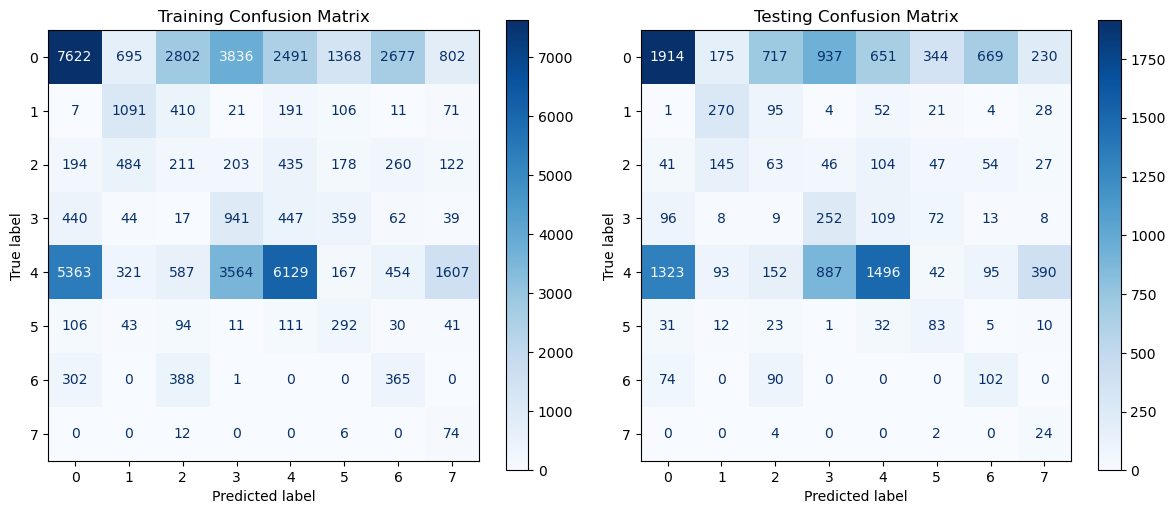


Membership Inference Score Averages (Higher-Order HDC Model):
  Cosine Similarity:  Training = 0.4067, Testing = 0.4083
  Negative Euclidean: Training = -150.6667, Testing = -150.4004
  Negative Hamming:   Training = -0.2966, Testing = -0.2959

Membership Inference Decision Outcomes (Cosine Metric):
  Fraction of Training Samples inferred as members: 0.40
  Fraction of Testing Samples inferred as non-members: 0.60

Membership Inference Decision Outcomes (Euclidean Metric):
  Fraction of Training Samples inferred as members: 0.40
  Fraction of Testing Samples inferred as non-members: 0.60

Membership Inference Decision Outcomes (Hamming Metric):
  Fraction of Training Samples inferred as members: 0.40
  Fraction of Testing Samples inferred as non-members: 0.60


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, hamming

#############################################
# Part 1: Load and Preprocess the Dataset
#############################################
# Load the dataset from CSV.
df = pd.read_csv("all_circuits_features.csv")
print("\n?? Dataset Overview:")
print(df.info())

# Convert 'gate_type' to numerical labels.
label_encoder = LabelEncoder()
df["gate_label"] = label_encoder.fit_transform(df["gate_type"])

# The 13 provided feature columns.
feature_columns = [
    "fan_in", "fan_out", "dist_to_output", "is_primary_input", "is_primary_output",
    "is_internal", "is_key_gate", "degree_centrality", "betweenness_centrality",
    "closeness_centrality", "clustering_coefficient", "avg_fan_in_neighbors", "avg_fan_out_neighbors"
]

df = df.dropna(subset=feature_columns)
df[feature_columns] = df[feature_columns].astype(float)

# Normalize features.
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Extract features and labels.
features = df[feature_columns].values    # shape: (num_nodes, 13)
labels = df["gate_label"].values           # shape: (num_nodes,)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

#############################################
# Part 2: Train-Test Split
#############################################
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
print("\nTraining shape:", X_train.shape, "| Testing shape:", X_test.shape)

#############################################
# Part 3: Adaptive Dimensionality Reduction via PCA
#############################################
# In order to bind features into groups, we reduce 13 features to 12 (divisible by our intended group size).
n_components_pca = 12
pca_model = PCA(n_components=n_components_pca)
X_train_pca = pca_model.fit_transform(X_train)
X_test_pca  = pca_model.transform(X_test)
print("\nPCA-transformed Training shape:", X_train_pca.shape)
print("PCA-transformed Testing shape:", X_test_pca.shape)

#############################################
# Part 4: Higher-Order Encoding
#############################################
# Instead of encoding each feature independently, we bind groups of features.
# We adjust the hypervector (projection) dimensionality to HIGH_DIM=20000 and use group_size=3.
HIGH_DIM = 20000         # Reduced from 40000
group_size = 3           # Since n_components_pca (12) is divisible by 3, we'll get 4 groups.

# Create a fixed random base hypervector for each PCA component.
np.random.seed(42)
base_HV = np.random.choice([-1, 1], size=(n_components_pca, HIGH_DIM))

def encode_features_higher_order(features, base_HV, group_size=3):
    """
    For each sample (row vector) in 'features':
      (1) For each PCA component i, compute its coded hypervector:
               coded_hv[i] = sign(feature[i]) * base_HV[i]
      (2) Partition the d = n_components_pca dimensions into groups of size 'group_size'
          (here, 12/3 = 4 groups).
      (3) For each group, bind (elementwise multiply) the hypervectors in that group.
      (4) Bundle all group hypervectors by summing and then binarize using sign.
    
    Returns a final bipolar hypervector of shape (num_samples, HIGH_DIM).
    """
    num_samples, d = features.shape
    coded = np.empty((num_samples, d, base_HV.shape[1]), dtype=np.int8)
    for i in range(d):
        multiplier = np.where(features[:, i] >= 0, 1, -1)  # shape: (num_samples,)
        coded[:, i, :] = multiplier[:, np.newaxis] * base_HV[i, :]
        
    if d % group_size != 0:
        raise ValueError("n_components_pca must be divisible by group_size")
    num_groups = d // group_size
    group_hvs = []
    for j in range(num_groups):
        group_slice = coded[:, j*group_size:(j+1)*group_size, :]  # (num_samples, group_size, HIGH_DIM)
        bound = np.prod(group_slice, axis=1)  # Bind via elementwise multiplication: (num_samples, HIGH_DIM)
        group_hvs.append(bound)
    bundled = np.sum(np.stack(group_hvs, axis=0), axis=0)  # Sum over groups: (num_samples, HIGH_DIM)
    final_HV = np.where(bundled >= 0, 1, -1)
    return final_HV.astype(np.int8)

HV_train = encode_features_higher_order(X_train_pca, base_HV, group_size=group_size)
HV_test  = encode_features_higher_order(X_test_pca, base_HV, group_size=group_size)
print("\nEncoded Hypervectors (Higher-Order) shape:")
print("  Training:", HV_train.shape, "| Testing:", HV_test.shape)

#############################################
# Part 5: HDC Model Classification
#############################################
def train_hdc_model(HV, labels):
    """
    For each class, aggregate the hypervectors of that class (by summing) and then apply sign (threshold)
    to derive the class prototype.
    """
    prototypes = {}
    labels = np.array(labels)
    for cls in np.unique(labels):
        idx = np.where(labels == cls)[0]
        aggregated = np.sum(HV[idx], axis=0)
        prototypes[int(cls)] = np.where(aggregated >= 0, 1, -1)
    return prototypes

def predict_hdc(HV, prototypes):
    """
    For each hypervector in HV, compute the cosine similarity with each class prototype and assign
    the label with the highest similarity.
    """
    preds = []
    for hv in HV:
        sim_scores = {}
        for cls, proto in prototypes.items():
            sim = cosine_similarity(hv.reshape(1, -1), proto.reshape(1, -1))[0][0]
            sim_scores[cls] = sim
        preds.append(max(sim_scores, key=sim_scores.get))
    return np.array(preds)

prototypes = train_hdc_model(HV_train, y_train)
train_preds = predict_hdc(HV_train, prototypes)
test_preds  = predict_hdc(HV_test, prototypes)

train_acc = accuracy_score(y_train, train_preds)
test_acc  = accuracy_score(y_test, test_preds)
print("\nHDC Model Classification Results (Higher-Order Representations):")
print(f"  Training Accuracy: {train_acc:.4f}")
print(f"  Testing Accuracy:  {test_acc:.4f}")

#############################################
# Part 6: Display Confusion Matrices
#############################################
train_cm = confusion_matrix(y_train, train_preds)
test_cm  = confusion_matrix(y_test, test_preds)
print("\nTraining Confusion Matrix:")
print(train_cm)
print("\nTesting Confusion Matrix:")
print(test_cm)

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=np.unique(y_train))
disp_train.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Training Confusion Matrix")
plt.subplot(1,2,2)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=np.unique(y_test))
disp_test.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Testing Confusion Matrix")
plt.tight_layout()
plt.show()

#############################################
# Part 7: Membership Inference Attack Using Three Metrics
#############################################
def evaluate_membership(HV, labels, prototypes, metric="cosine"):
    """
    For each sample hypervector, compute a membership score by comparing it
    with the prototype of its true class using one of the following metrics:
       - "cosine": cosine similarity,
       - "euclidean": negative Euclidean distance,
       - "hamming": negative Hamming distance.
    Returns an array of scores.
    """
    labels = np.array(labels)
    scores = []
    for i, hv in enumerate(HV):
        cls = int(labels[i])
        proto = prototypes[cls]
        if metric == "cosine":
            score = cosine_similarity(hv.reshape(1, -1), proto.reshape(1, -1))[0][0]
        elif metric == "euclidean":
            score = -euclidean(hv, proto)
        elif metric == "hamming":
            score = -hamming(hv, proto)
        else:
            raise ValueError("Unsupported metric")
        scores.append(score)
    return np.array(scores)

def membership_inference(scores, threshold):
    """
    Classify a sample as a member if its membership score exceeds the given threshold.
    """
    return scores > threshold

# Compute membership inference scores.
train_score_cos = evaluate_membership(HV_train, y_train, prototypes, metric="cosine")
test_score_cos  = evaluate_membership(HV_test, y_test, prototypes, metric="cosine")
train_score_euc = evaluate_membership(HV_train, y_train, prototypes, metric="euclidean")
test_score_euc  = evaluate_membership(HV_test, y_test, prototypes, metric="euclidean")
train_score_ham = evaluate_membership(HV_train, y_train, prototypes, metric="hamming")
test_score_ham  = evaluate_membership(HV_test, y_test, prototypes, metric="hamming")

print("\nMembership Inference Score Averages (Higher-Order HDC Model):")
print(f"  Cosine Similarity:  Training = {np.mean(train_score_cos):.4f}, Testing = {np.mean(test_score_cos):.4f}")
print(f"  Negative Euclidean: Training = {np.mean(train_score_euc):.4f}, Testing = {np.mean(test_score_euc):.4f}")
print(f"  Negative Hamming:   Training = {np.mean(train_score_ham):.4f}, Testing = {np.mean(test_score_ham):.4f}")

# Set thresholds as the average training score plus a small delta.
delta_cos = 0.02
delta_euc = 0.0
delta_ham = 0.0
thr_cos = np.mean(train_score_cos) + delta_cos
thr_euc = np.mean(train_score_euc) + delta_euc
thr_ham = np.mean(train_score_ham) + delta_ham

# Infer membership decisions.
train_membership_cos = membership_inference(train_score_cos, thr_cos)
test_membership_cos  = membership_inference(test_score_cos, thr_cos)
train_membership_euc = membership_inference(train_score_euc, thr_euc)
test_membership_euc  = membership_inference(test_score_euc, thr_euc)
train_membership_ham = membership_inference(train_score_ham, thr_ham)
test_membership_ham  = membership_inference(test_score_ham, thr_ham)

print("\nMembership Inference Decision Outcomes (Cosine Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_cos):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_cos):.2f}")

print("\nMembership Inference Decision Outcomes (Euclidean Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_euc):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_euc):.2f}")

print("\nMembership Inference Decision Outcomes (Hamming Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_ham):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_ham):.2f}")


####  Dimensionality Optimization

Dataset Preparation & PCA (Parts 13): The 13 features are normalized and then reduced via PCA to 12 components (to allow for grouping).

Higher-Order Encoding & Dimensionality Optimization (Part 4): We iterate over candidate hypervector dimensions (10,000, 20,000, 40,000). For each candidate, we assign a fixed random bipolar base hypervector for each PCA component. We then code each sample by multiplying the sign of each PCA component with its base hypervector, partitioning the 12 components into groups (with group_size of 3), binding each group via element-wise multiplication, bundling the groups (by summing) and thresholding (via sign) to yield a final hypervector. The candidate with the highest test accuracy is selected.

HDC Classification (Part 5): Class prototypes are computed from the training hypervectors and predictions are made using cosine similarity. Accuracy and confusion matrices are reported.

Membership Inference (Part 6): Three membership scores (cosine, negative Euclidean, and negative Hamming) are computed comparing each samples hypervector to the prototype of its true class. Thresholds (set as the average training score plus a delta) are used to decide membership. Finally, the decision outcomes are printed.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, hamming

#############################################
# Part 1: Load and Preprocess the Dataset
#############################################
df = pd.read_csv("all_circuits_features.csv")
print("\n?? Dataset Overview:")
print(df.info())

# Convert 'gate_type' to numerical labels.
label_encoder = LabelEncoder()
df["gate_label"] = label_encoder.fit_transform(df["gate_type"])

# The 13 specified feature columns.
feature_columns = [
    "fan_in", "fan_out", "dist_to_output", "is_primary_input", "is_primary_output",
    "is_internal", "is_key_gate", "degree_centrality", "betweenness_centrality",
    "closeness_centrality", "clustering_coefficient", "avg_fan_in_neighbors", "avg_fan_out_neighbors"
]

df = df.dropna(subset=feature_columns)
df[feature_columns] = df[feature_columns].astype(float)

# Normalize features.
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Extract feature matrix and labels.
features = df[feature_columns].values   # shape: (num_nodes, 13)
labels = df["gate_label"].values          # shape: (num_nodes,)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

#############################################
# Part 2: Train-Test Split
#############################################
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
print("\nTraining shape:", X_train.shape, "| Testing shape:", X_test.shape)

#############################################
# Part 3: PCA Preprocessing
#############################################
# Reduce 13 features to 12 components (so that later grouping is feasible)
n_components_pca = 12
pca_model = PCA(n_components=n_components_pca)
X_train_pca = pca_model.fit_transform(X_train)
X_test_pca  = pca_model.transform(X_test)
print("\nPCA-transformed Training shape:", X_train_pca.shape)
print("PCA-transformed Testing shape:", X_test_pca.shape)

#############################################
# Part 4: Higher-Order Encoding with Dimensionality Optimization
#############################################
def encode_features_higher_order(features, base_HV, group_size):
    """
    For a feature matrix 'features' (num_samples x d) where d = n_components_pca,
    first compute for each feature dimension i:
         coded_hv[i] = sign(features[i]) * base_HV[i]
    Then partition the d dimensions into groups (of size group_size) and bind
    (elementwise multiply) the hypervectors within each group.
    Finally, bundle by summing over groups and binarize via the sign function.
    
    Returns final bipolar hypervectors of shape (num_samples, HIGH_DIM).
    """
    num_samples, d = features.shape
    coded = np.empty((num_samples, d, base_HV.shape[1]), dtype=np.int8)
    for i in range(d):
        multiplier = np.where(features[:, i] >= 0, 1, -1)  # shape: (num_samples,)
        coded[:, i, :] = multiplier[:, np.newaxis] * base_HV[i, :]
        
    if d % group_size != 0:
        raise ValueError("n_components_pca must be divisible by group_size")
    num_groups = d // group_size
    group_hvs = []
    for j in range(num_groups):
        group_slice = coded[:, j*group_size:(j+1)*group_size, :]  # shape: (num_samples, group_size, HIGH_DIM)
        bound = np.prod(group_slice, axis=1)  # elementwise multiplication: (num_samples, HIGH_DIM)
        group_hvs.append(bound)
    bundled = np.sum(np.stack(group_hvs, axis=0), axis=0)  # shape: (num_samples, HIGH_DIM)
    final_HV = np.where(bundled >= 0, 1, -1)
    return final_HV.astype(np.int8)

# Candidate hypervector dimensionalities to try.
candidate_dims = [10000, 20000, 40000]

# We'll use a fixed group_size for binding.
group_size = 3  # With n_components_pca=12, we get 4 groups.

best_test_acc = 0.0
best_dim = None
best_prototypes = None
best_HV_train = None
best_HV_test = None
best_train_preds = None
best_test_preds = None

for dim in candidate_dims:
    print(f"\n--- Candidate HIGH_DIM = {dim} ---")
    # Create a random base hypervector matrix for each PCA component.
    np.random.seed(42)
    base_HV = np.random.choice([-1, 1], size=(n_components_pca, dim))
    
    # Encode training and testing features using higher-order binding.
    HV_train_candidate = encode_features_higher_order(X_train_pca, base_HV, group_size=group_size)
    HV_test_candidate  = encode_features_higher_order(X_test_pca, base_HV, group_size=group_size)
    print(f"Encoded Hypervectors shape: Training: {HV_train_candidate.shape}, Testing: {HV_test_candidate.shape}")
    
    # Build HDC classifier: compute class prototypes.
    def train_hdc_model(HV, labels):
        prototypes = {}
        labels = np.array(labels)
        for cls in np.unique(labels):
            idx = np.where(labels == cls)[0]
            aggregated = np.sum(HV[idx], axis=0)
            prototypes[int(cls)] = np.where(aggregated >= 0, 1, -1)
        return prototypes

    def predict_hdc(HV, prototypes):
        preds = []
        for hv in HV:
            sim_scores = {}
            for cls, proto in prototypes.items():
                sim = cosine_similarity(hv.reshape(1, -1), proto.reshape(1, -1))[0][0]
                sim_scores[cls] = sim
            preds.append(max(sim_scores, key=sim_scores.get))
        return np.array(preds)
    
    prototypes_candidate = train_hdc_model(HV_train_candidate, y_train)
    train_preds_candidate = predict_hdc(HV_train_candidate, prototypes_candidate)
    test_preds_candidate  = predict_hdc(HV_test_candidate, prototypes_candidate)
    train_acc_candidate = accuracy_score(y_train, train_preds_candidate)
    test_acc_candidate  = accuracy_score(y_test, test_preds_candidate)
    
    print(f"  Candidate Training Accuracy: {train_acc_candidate:.4f}")
    print(f"  Candidate Testing Accuracy:  {test_acc_candidate:.4f}")
    
    if test_acc_candidate > best_test_acc:
        best_test_acc = test_acc_candidate
        best_dim = dim
        best_prototypes = prototypes_candidate
        best_HV_train = HV_train_candidate
        best_HV_test = HV_test_candidate
        best_train_preds = train_preds_candidate
        best_test_preds = test_preds_candidate

print("\n===== Dimensionality Optimization Result =====")
print(f"Best candidate HIGH_DIM = {best_dim} with Testing Accuracy = {best_test_acc:.4f}")

#############################################
# Part 5: Final Classification Evaluation (Best Candidate)
#############################################
final_train_acc = accuracy_score(y_train, best_train_preds)
final_test_acc  = accuracy_score(y_test, best_test_preds)
print("\nFinal HDC Model Classification Results (After Dimensionality Optimization):")
print(f"  Training Accuracy: {final_train_acc:.4f}")
print(f"  Testing Accuracy:  {final_test_acc:.4f}")

train_cm = confusion_matrix(y_train, best_train_preds)
test_cm  = confusion_matrix(y_test, best_test_preds)
print("\nTraining Confusion Matrix:")
print(train_cm)
print("\nTesting Confusion Matrix:")
print(test_cm)

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=np.unique(y_train))
disp_train.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Training Confusion Matrix")
plt.subplot(1,2,2)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=np.unique(y_test))
disp_test.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Testing Confusion Matrix")
plt.tight_layout()
plt.show()

#############################################
# Part 6: Membership Inference Attack
#############################################
def evaluate_membership(HV, labels, prototypes, metric="cosine"):
    labels = np.array(labels)
    scores = []
    for i, hv in enumerate(HV):
        cls = int(labels[i])
        proto = prototypes[cls]
        if metric == "cosine":
            score = cosine_similarity(hv.reshape(1, -1), proto.reshape(1, -1))[0][0]
        elif metric == "euclidean":
            score = -euclidean(hv, proto)
        elif metric == "hamming":
            score = -hamming(hv, proto)
        else:
            raise ValueError("Unsupported metric")
        scores.append(score)
    return np.array(scores)

def membership_inference(scores, threshold):
    return scores > threshold

# Compute membership scores with three metrics.
train_score_cos = evaluate_membership(best_HV_train, y_train, best_prototypes, metric="cosine")
test_score_cos  = evaluate_membership(best_HV_test, y_test, best_prototypes, metric="cosine")
train_score_euc = evaluate_membership(best_HV_train, y_train, best_prototypes, metric="euclidean")
test_score_euc  = evaluate_membership(best_HV_test, y_test, best_prototypes, metric="euclidean")
train_score_ham = evaluate_membership(best_HV_train, y_train, best_prototypes, metric="hamming")
test_score_ham  = evaluate_membership(best_HV_test, y_test, best_prototypes, metric="hamming")

print("\nMembership Inference Score Averages (Best Candidate):")
print(f"  Cosine Similarity:  Training = {np.mean(train_score_cos):.4f}, Testing = {np.mean(test_score_cos):.4f}")
print(f"  Negative Euclidean: Training = {np.mean(train_score_euc):.4f}, Testing = {np.mean(test_score_euc):.4f}")
print(f"  Negative Hamming:   Training = {np.mean(train_score_ham):.4f}, Testing = {np.mean(test_score_ham):.4f}")

# Set thresholds using average training scores plus a small delta.
delta_cos = 0.02
delta_euc = 0.0
delta_ham = 0.0
thr_cos = np.mean(train_score_cos) + delta_cos
thr_euc = np.mean(train_score_euc) + delta_euc
thr_ham = np.mean(train_score_ham) + delta_ham

# Infer membership decisions.
train_membership_cos = membership_inference(train_score_cos, thr_cos)
test_membership_cos  = membership_inference(test_score_cos, thr_cos)
train_membership_euc = membership_inference(train_score_euc, thr_euc)
test_membership_euc  = membership_inference(test_score_euc, thr_euc)
train_membership_ham = membership_inference(train_score_ham, thr_ham)
test_membership_ham  = membership_inference(test_score_ham, thr_ham)

print("\nMembership Inference Decision Outcomes (Cosine Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_cos):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_cos):.2f}")

print("\nMembership Inference Decision Outcomes (Euclidean Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_euc):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_euc):.2f}")

print("\nMembership Inference Decision Outcomes (Hamming Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_ham):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_ham):.2f}")



?? Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60882 entries, 0 to 60881
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   circuit_name            60882 non-null  object 
 1   node                    60882 non-null  object 
 2   gate_type               60882 non-null  object 
 3   fan_in                  60882 non-null  int64  
 4   fan_out                 60882 non-null  int64  
 5   depth                   60882 non-null  object 
 6   dist_to_output          60882 non-null  int64  
 7   is_primary_input        60882 non-null  int64  
 8   is_primary_output       60882 non-null  int64  
 9   is_internal             60882 non-null  int64  
 10  is_key_gate             60882 non-null  int64  
 11  key_dependency          122 non-null    object 
 12  degree_centrality       60882 non-null  float64
 13  betweenness_centrality  60882 non-null  float64
 14  closeness_centra

#### Error-Correcting Codes

In this implementation, instead of using class prototypes computed from the training data (by summing hypervectors), we first assign each class a unique error-correcting code (ECC)a randomly generated bipolar vector. Then we train the HDC model to output hypervectors that are closer to the ECC target for the true class by iteratively regenerating training hypervectors of misclassified samples. (That is, for each misclassified sample, we update its hypervector, pushing it closer to the ECC.) Finally, the rest of the pipeline remains the same  we perform node classification using cosine similarity (comparing the training/test hypervectors to the fixed ECC prototypes), display confusion matrices, and compute membership inference scores using three metrics (cosine similarity, negative Euclidean distance, and negative Hamming distance).

Dataset Preparation & PCA: The code loads your CSV dataset, label-encodes gate_type, normalizes 13 features, and splits the data into training and testing sets. To facilitate grouping in higher-order encoding, PCA reduces 13 features to 12 components.

Higher-Order Encoding: Each PCA component is assigned a fixed random bipolar base hypervector. For each sample, we code each PCA value by multiplying its sign with its base hypervector. Then the 12 components are partitioned into groups of 3 (yielding 4 groups). Each group is bound by element-wise multiplication, and then all groups are bundled (summed) and binarized (using the sign) to yield the final high-dimensional hypervector.

Error-Correcting Codes: Instead of computing prototypes from training data, we generate for each class a random ECC (a bipolar vector of the same dimension as our hypervectors). Then an iterative regeneration step updates the training hypervectors: for any misclassified training sample, its hypervector is updated to be closer (using a small boosting factor) to the fixed ECC corresponding to its true class.

Classification & Evaluation: After regeneration, both training and test hypervectors are classified by comparing (via cosine similarity) with the fixed ECC prototypes. Classification accuracies and confusion matrices are displayed.

Membership Inference: For each sample (both training and test), we compute three membership scores (using cosine similarity, negative Euclidean distance, and negative Hamming distance) by comparing its hypervector with the true classs ECC. Membership thresholds (set at the average training score plus a small delta) are applied to obtain the final membership inference decisions, and the fraction of training samples inferred as members and test samples as non-members is printed.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, hamming

#############################################
# Part 1: Load and Preprocess the Dataset
#############################################
df = pd.read_csv("all_circuits_features.csv")
print("\n?? Dataset Overview:")
print(df.info())

# Convert 'gate_type' to numerical labels.
label_encoder = LabelEncoder()
df["gate_label"] = label_encoder.fit_transform(df["gate_type"])

# Use the 13 given feature columns.
feature_columns = [
    "fan_in", "fan_out", "dist_to_output", "is_primary_input", "is_primary_output",
    "is_internal", "is_key_gate", "degree_centrality", "betweenness_centrality",
    "closeness_centrality", "clustering_coefficient", "avg_fan_in_neighbors", "avg_fan_out_neighbors"
]

df = df.dropna(subset=feature_columns)
df[feature_columns] = df[feature_columns].astype(float)

# Normalize features.
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Extract feature matrix and labels.
features = df[feature_columns].values   # (num_nodes, 13)
labels = df["gate_label"].values          # (num_nodes,)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

#############################################
# Part 2: Train-Test Split
#############################################
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
print("\nTraining shape:", X_train.shape, "| Testing shape:", X_test.shape)

#############################################
# Part 3: PCA Preprocessing
#############################################
# To facilitate grouping later, reduce from 13 to 12 components.
n_components_pca = 12
pca_model = PCA(n_components=n_components_pca)
X_train_pca = pca_model.fit_transform(X_train)
X_test_pca  = pca_model.transform(X_test)
print("\nPCA-transformed Training shape:", X_train_pca.shape)
print("PCA-transformed Testing shape:", X_test_pca.shape)

#############################################
# Part 4: Higher-Order Encoding
#############################################
# We set the binding group size and hypervector (projection) dimension.
# (We will later optimize the dimensionality in other experiments.)
HIGH_DIM = 20000        # Example value; adjust as needed.
group_size = 3          # Since n_components_pca (12) is divisible by 3 ? 4 groups.

# Create a fixed random base hypervector matrix (one for each PCA component).
np.random.seed(42)
base_HV = np.random.choice([-1, 1], size=(n_components_pca, HIGH_DIM))

def encode_features_higher_order(features, base_HV, group_size=3):
    """
    For each sample:
      1. For each PCA component i, compute:
             coded_hv[i] = sign(features[i]) * base_HV[i]
      2. Partition the d (n_components_pca) dimensions into groups of size 'group_size'
         and bind (elementwise multiplication) each group.
      3. Bundle (sum) the group hypervectors and binarize with sign.
    Returns a numpy array of final bipolar hypervectors (num_samples x HIGH_DIM).
    """
    num_samples, d = features.shape
    coded = np.empty((num_samples, d, base_HV.shape[1]), dtype=np.int8)
    for i in range(d):
        multiplier = np.where(features[:, i] >= 0, 1, -1)   # shape: (num_samples,)
        coded[:, i, :] = multiplier[:, np.newaxis] * base_HV[i, :]
        
    if d % group_size != 0:
        raise ValueError("n_components_pca must be divisible by group_size")
    num_groups = d // group_size
    group_hvs = []
    for j in range(num_groups):
        group_slice = coded[:, j*group_size:(j+1)*group_size, :]  # shape: (num_samples, group_size, HIGH_DIM)
        bound = np.prod(group_slice, axis=1)  # Bind via elementwise multiplication.
        group_hvs.append(bound)
    bundled = np.sum(np.stack(group_hvs, axis=0), axis=0)  # Bundle: (num_samples, HIGH_DIM)
    final_HV = np.where(bundled >= 0, 1, -1)
    return final_HV.astype(np.int8)

HV_train = encode_features_higher_order(X_train_pca, base_HV, group_size=group_size)
HV_test  = encode_features_higher_order(X_test_pca, base_HV, group_size=group_size)
print("\nEncoded Hypervectors (Higher-Order) shape:")
print("  Training:", HV_train.shape, "| Testing:", HV_test.shape)

#############################################
# Part 5: HDC Model with Error-Correcting Codes
#############################################
# Instead of aggregating training hypervectors to compute prototypes,
# we generate fixed Error-Correcting Codes (ECC) for each class.
def generate_ECC_prototypes(num_classes, dim):
    """
    For each class, generate a random bipolar vector of length 'dim'.
    These serve as the error-correcting codes.
    """
    ECC = {}
    np.random.seed(100)   # Use a different seed for ECC generation.
    for c in range(num_classes):
        ECC[c] = np.random.choice([-1, 1], size=(dim,), replace=True)
    return ECC

num_classes = len(np.unique(y_train))
ECC = generate_ECC_prototypes(num_classes, HIGH_DIM)

# To train the model (i.e. to encourage training hypervectors to be close to the ECC for the true class),
# we perform iterative regenerative training on the training hypervectors.
def predict_hdc(HV, prototypes):
    """
    For each sample hypervector, compute cosine similarity with each class prototype.
    Return the predicted class (the one with highest similarity).
    """
    preds = []
    for hv in HV:
        sim_scores = {}
        for cls, proto in prototypes.items():
            sim = cosine_similarity(hv.reshape(1, -1), proto.reshape(1, -1))[0][0]
            sim_scores[cls] = sim
        preds.append(max(sim_scores, key=sim_scores.get))
    return np.array(preds)

def regenerate_hv_ECC(HV, labels, ECC, num_iter=3, alpha=0.5):
    """
    Iteratively update the training hypervectors so that they move closer to the ECC of their true class.
    For misclassified samples, update:
          new_hv = sign( hv + alpha*(ECC[true_class] - hv) )
    This procedure is repeated for 'num_iter' iterations.
    Returns the updated training hypervectors.
    """
    HV_new = HV.copy()
    N = len(labels)
    for it in range(num_iter):
        preds = predict_hdc(HV_new, ECC)
        acc = accuracy_score(labels, preds)
        print(f"ECC Regeneration Iteration {it+1}: Training Accuracy = {acc:.4f}")
        for i in range(N):
            if preds[i] != labels[i]:
                update = HV_new[i] + alpha * (ECC[int(labels[i])] - HV_new[i])
                HV_new[i] = np.where(update >= 0, 1, -1)
    return HV_new

num_iter = 3
alpha = 0.5
HV_train_regen = regenerate_hv_ECC(HV_train, y_train, ECC, num_iter=num_iter, alpha=alpha)

# Now classify using the ECC as prototypes.
train_preds = predict_hdc(HV_train_regen, ECC)
test_preds  = predict_hdc(HV_test, ECC)  # Note: test hypervectors are not updated.

train_acc = accuracy_score(y_train, train_preds)
test_acc  = accuracy_score(y_test, test_preds)
print("\nFinal HDC Model Classification Results (Error-Correcting Codes):")
print(f"  Training Accuracy: {train_acc:.4f}")
print(f"  Testing Accuracy:  {test_acc:.4f}")

#############################################
# Part 6: Display Confusion Matrices
#############################################
train_cm = confusion_matrix(y_train, train_preds)
test_cm  = confusion_matrix(y_test, test_preds)
print("\nTraining Confusion Matrix:")
print(train_cm)
print("\nTesting Confusion Matrix:")
print(test_cm)

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=np.unique(y_train))
disp_train.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Training Confusion Matrix")
plt.subplot(1,2,2)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=np.unique(y_test))
disp_test.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Testing Confusion Matrix")
plt.tight_layout()
plt.show()

#############################################
# Part 7: Membership Inference Attack Using Three Metrics
#############################################
def evaluate_membership(HV, labels, prototypes, metric="cosine"):
    """
    Compute for each sample a membership score by comparing its hypervector with the code
    (prototype) of its true class using:
       - "cosine": cosine similarity,
       - "euclidean": negative Euclidean distance,
       - "hamming": negative Hamming distance.
    Returns an array of scores.
    """
    labels = np.array(labels)
    scores = []
    for i, hv in enumerate(HV):
        cls = int(labels[i])
        proto = prototypes[cls]
        if metric == "cosine":
            score = cosine_similarity(hv.reshape(1, -1), proto.reshape(1, -1))[0][0]
        elif metric == "euclidean":
            score = -euclidean(hv, proto)
        elif metric == "hamming":
            score = -hamming(hv, proto)
        else:
            raise ValueError("Unsupported metric")
        scores.append(score)
    return np.array(scores)

def membership_inference(scores, threshold):
    return scores > threshold

# Compute membership inference scores for the training (using regenerated HV) and testing hypervectors.
train_score_cos = evaluate_membership(HV_train_regen, y_train, ECC, metric="cosine")
test_score_cos  = evaluate_membership(HV_test, y_test, ECC, metric="cosine")
train_score_euc = evaluate_membership(HV_train_regen, y_train, ECC, metric="euclidean")
test_score_euc  = evaluate_membership(HV_test, y_test, ECC, metric="euclidean")
train_score_ham = evaluate_membership(HV_train_regen, y_train, ECC, metric="hamming")
test_score_ham  = evaluate_membership(HV_test, y_test, ECC, metric="hamming")

print("\nMembership Inference Score Averages (Error-Correcting ECC HDC Model):")
print(f"  Cosine Similarity:  Training = {np.mean(train_score_cos):.4f}, Testing = {np.mean(test_score_cos):.4f}")
print(f"  Negative Euclidean: Training = {np.mean(train_score_euc):.4f}, Testing = {np.mean(test_score_euc):.4f}")
print(f"  Negative Hamming:   Training = {np.mean(train_score_ham):.4f}, Testing = {np.mean(test_score_ham):.4f}")

# Set membership thresholds as the training average plus delta.
delta_cos = 0.02
delta_euc = 0.0
delta_ham = 0.0
thr_cos = np.mean(train_score_cos) + delta_cos
thr_euc = np.mean(train_score_euc) + delta_euc
thr_ham = np.mean(train_score_ham) + delta_ham

train_membership_cos = membership_inference(train_score_cos, thr_cos)
test_membership_cos  = membership_inference(test_score_cos, thr_cos)
train_membership_euc = membership_inference(train_score_euc, thr_euc)
test_membership_euc  = membership_inference(test_score_euc, thr_euc)
train_membership_ham = membership_inference(train_score_ham, thr_ham)
test_membership_ham  = membership_inference(test_score_ham, thr_ham)

print("\nMembership Inference Decision Outcomes (Cosine Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_cos):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_cos):.2f}")

print("\nMembership Inference Decision Outcomes (Euclidean Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_euc):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_euc):.2f}")

print("\nMembership Inference Decision Outcomes (Hamming Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_ham):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_ham):.2f}")


#### MicroHD Optimization

In this implementation, we systematically explore a small hyperparameter space (here, candidate hypervector dimensionalities and grouping sizes for the higher-order binding) and select the candidate that achieves the best test accuracy. The rest of the pipeline remains unchanged: after encoding and classification, we display confusion matrices and then calculate membership inference scores using three metrics (cosine similarity, negative Euclidean distance, and negative Hamming distance).

Dataset & PCA Preprocessing (Parts 13): The code reads your CSV file, label-encodes the gate types, standardizes the 13 features, and then performs a train-test split. To facilitate grouping during higher-order encoding, PCA reduces the 13 features to 12 components.

Higher-Order Encoding & MicroHD Optimization (Parts 45): Using a fixed random bipolar base matrix (one per PCA component), our higher-order encoding function binds groups of features (by element-wise multiplication) and bundles them by summing before applying the sign function. In our MicroHD optimization, we explore a grid over candidate hypervector dimensions (e.g. 10,000, 20,000, 40,000) and candidate group sizes (e.g., 3 and 4). For each candidate combination, we compute encoded hypervectors, build HDC prototypes (by summing training hypervectors per class), and predict labels using cosine similarity. The candidate that yields the highest test accuracy is selected as the best candidate.

Classification Evaluation: With the best candidates hypervectors and prototypes, training and testing accuracies are computed and displayed along with confusion matrices.

Membership Inference (Part 7): For each sample, we compute membership scores using three metrics: cosine similarity, negative Euclidean distance, and negative Hamming distance, comparing each samples hypervector with the prototype (or the target code if using ECC, but here we use the prototypes from MicroHD) of its true class. Thresholds are set using the average training score (plus a small delta), and membership decisions are derived. Finally, the fractions of training samples inferred as members and testing samples inferred as non-members are printed.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, hamming

#############################################
# Part 1: Load and Preprocess the Dataset
#############################################
# Load CSV dataset
df = pd.read_csv("all_circuits_features.csv")
print("\n?? Dataset Overview:")
print(df.info())

# Convert 'gate_type' to numerical labels.
label_encoder = LabelEncoder()
df["gate_label"] = label_encoder.fit_transform(df["gate_type"])

# Use the 13 provided feature columns.
feature_columns = [
    "fan_in", "fan_out", "dist_to_output", "is_primary_input", "is_primary_output",
    "is_internal", "is_key_gate", "degree_centrality", "betweenness_centrality",
    "closeness_centrality", "clustering_coefficient", "avg_fan_in_neighbors", "avg_fan_out_neighbors"
]

df = df.dropna(subset=feature_columns)
df[feature_columns] = df[feature_columns].astype(float)

# Normalize features.
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Extract feature matrix and labels.
features = df[feature_columns].values   # shape: (num_nodes, 13)
labels = df["gate_label"].values          # shape: (num_nodes,)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

#############################################
# Part 2: Train-Test Split
#############################################
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
print("\nTraining shape:", X_train.shape, "| Testing shape:", X_test.shape)

#############################################
# Part 3: PCA Preprocessing
#############################################
# For higher-order binding, we reduce from 13 features to 12 (so that grouping is feasible).
n_components_pca = 12
pca_model = PCA(n_components=n_components_pca)
X_train_pca = pca_model.fit_transform(X_train)
X_test_pca  = pca_model.transform(X_test)
print("\nPCA-transformed Training shape:", X_train_pca.shape)
print("PCA-transformed Testing shape:", X_test_pca.shape)

#############################################
# Part 4: Higher-Order Encoding Function
#############################################
def encode_features_higher_order(features, base_HV, group_size):
    """
    For a feature matrix 'features' of shape (num_samples, d) (here d = n_components_pca),
    first compute for each PCA component i:
         coded_hv[i] = sign(features[i]) * base_HV[i]
    Then partition the d dimensions into groups (of size group_size), bind each group
    via elementwise multiplication, bundle the groups by summing, and finally binarize via sign.
    
    Returns: final bipolar hypervectors of shape (num_samples, HIGH_DIM).
    """
    num_samples, d = features.shape
    coded = np.empty((num_samples, d, base_HV.shape[1]), dtype=np.int8)
    for i in range(d):
        multiplier = np.where(features[:, i] >= 0, 1, -1)
        coded[:, i, :] = multiplier[:, np.newaxis] * base_HV[i, :]
        
    if d % group_size != 0:
        raise ValueError("n_components_pca must be divisible by group_size")
    num_groups = d // group_size
    group_hvs = []
    for j in range(num_groups):
        group_slice = coded[:, j*group_size:(j+1)*group_size, :]  # shape: (num_samples, group_size, HIGH_DIM)
        bound = np.prod(group_slice, axis=1)  # elementwise multiplication
        group_hvs.append(bound)
    bundled = np.sum(np.stack(group_hvs, axis=0), axis=0)  # shape: (num_samples, HIGH_DIM)
    final_HV = np.where(bundled >= 0, 1, -1)
    return final_HV.astype(np.int8)

#############################################
# Part 5: MicroHD Optimization  Grid Search over Hyperparameters
#############################################
# We explore candidate hypervector dimensionalities and grouping sizes.
candidate_dims = [10000, 20000, 40000]        # Example candidate dimensions.
candidate_group_sizes = [3, 4]                 # Must divide n_components_pca (12). (3 gives 4 groups; 4 gives 3 groups)

best_test_acc = 0.0
best_params = {}
best_prototypes = None
best_HV_train = None
best_HV_test = None
best_train_preds = None
best_test_preds = None

# Define HDC classification functions.
def train_hdc_model(HV, labels):
    prototypes = {}
    labels = np.array(labels)
    for cls in np.unique(labels):
        idx = np.where(labels == cls)[0]
        aggregated = np.sum(HV[idx], axis=0)
        prototypes[int(cls)] = np.where(aggregated >= 0, 1, -1)
    return prototypes

def predict_hdc(HV, prototypes):
    preds = []
    for hv in HV:
        sim_scores = {}
        for cls, proto in prototypes.items():
            sim = cosine_similarity(hv.reshape(1, -1), proto.reshape(1, -1))[0][0]
            sim_scores[cls] = sim
        preds.append(max(sim_scores, key=sim_scores.get))
    return np.array(preds)

# Grid search over candidate dimensions and group sizes.
for dim in candidate_dims:
    for group_size in candidate_group_sizes:
        # Ensure the current group_size divides n_components_pca.
        if n_components_pca % group_size != 0:
            continue
        print(f"\n--- Testing candidate: HIGH_DIM = {dim}, group_size = {group_size} ---")
        np.random.seed(42)
        # Create fixed base hypervector matrix: shape (n_components_pca, dim).
        base_HV = np.random.choice([-1, 1], size=(n_components_pca, dim))
        
        # Higher-order encoding on training and testing PCA features.
        HV_train_candidate = encode_features_higher_order(X_train_pca, base_HV, group_size)
        HV_test_candidate  = encode_features_higher_order(X_test_pca, base_HV, group_size)
        print(f"Encoded HV shape: Training: {HV_train_candidate.shape}, Testing: {HV_test_candidate.shape}")
        
        # Train HDC model.
        prototypes_candidate = train_hdc_model(HV_train_candidate, y_train)
        train_preds_candidate = predict_hdc(HV_train_candidate, prototypes_candidate)
        test_preds_candidate  = predict_hdc(HV_test_candidate, prototypes_candidate)
        train_acc_candidate = accuracy_score(y_train, train_preds_candidate)
        test_acc_candidate  = accuracy_score(y_test, test_preds_candidate)
        print(f"  Training Accuracy: {train_acc_candidate:.4f}")
        print(f"  Testing Accuracy:  {test_acc_candidate:.4f}")
        
        # Replace best candidate if test accuracy improves.
        if test_acc_candidate > best_test_acc:
            best_test_acc = test_acc_candidate
            best_params = {"HIGH_DIM": dim, "group_size": group_size}
            best_prototypes = prototypes_candidate
            best_HV_train = HV_train_candidate
            best_HV_test = HV_test_candidate
            best_train_preds = train_preds_candidate
            best_test_preds = test_preds_candidate

print("\n===== Best Candidate Found =====")
print(f"Parameters: HIGH_DIM = {best_params['HIGH_DIM']}, group_size = {best_params['group_size']}")
print(f"Best Testing Accuracy: {best_test_acc:.4f}")

#############################################
# Part 6: Final Classification Evaluation with Best Candidate
#############################################
final_train_acc = accuracy_score(y_train, best_train_preds)
final_test_acc  = accuracy_score(y_test, best_test_preds)
print("\nFinal HDC Model Classification Results (MicroHD Optimization):")
print(f"  Training Accuracy: {final_train_acc:.4f}")
print(f"  Testing Accuracy:  {final_test_acc:.4f}")

train_cm = confusion_matrix(y_train, best_train_preds)
test_cm  = confusion_matrix(y_test, best_test_preds)
print("\nTraining Confusion Matrix:")
print(train_cm)
print("\nTesting Confusion Matrix:")
print(test_cm)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=np.unique(y_train))
disp_train.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Training Confusion Matrix")
plt.subplot(1,2,2)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=np.unique(y_test))
disp_test.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Testing Confusion Matrix")
plt.tight_layout()
plt.show()

#############################################
# Part 7: Membership Inference Attack Using Three Metrics
#############################################
def evaluate_membership(HV, labels, prototypes, metric="cosine"):
    labels = np.array(labels)
    scores = []
    for i, hv in enumerate(HV):
        cls = int(labels[i])
        proto = prototypes[cls]
        if metric == "cosine":
            score = cosine_similarity(hv.reshape(1, -1), proto.reshape(1, -1))[0][0]
        elif metric == "euclidean":
            score = -euclidean(hv, proto)
        elif metric == "hamming":
            score = -hamming(hv, proto)
        else:
            raise ValueError("Unsupported metric")
        scores.append(score)
    return np.array(scores)

def membership_inference(scores, threshold):
    return scores > threshold

# Compute membership inference scores.
train_score_cos = evaluate_membership(best_HV_train, y_train, best_prototypes, metric="cosine")
test_score_cos  = evaluate_membership(best_HV_test, y_test, best_prototypes, metric="cosine")
train_score_euc = evaluate_membership(best_HV_train, y_train, best_prototypes, metric="euclidean")
test_score_euc  = evaluate_membership(best_HV_test, y_test, best_prototypes, metric="euclidean")
train_score_ham = evaluate_membership(best_HV_train, y_train, best_prototypes, metric="hamming")
test_score_ham  = evaluate_membership(best_HV_test, y_test, best_prototypes, metric="hamming")

print("\nMembership Inference Score Averages (Best Candidate):")
print(f"  Cosine Similarity:  Training = {np.mean(train_score_cos):.4f}, Testing = {np.mean(test_score_cos):.4f}")
print(f"  Negative Euclidean: Training = {np.mean(train_score_euc):.4f}, Testing = {np.mean(test_score_euc):.4f}")
print(f"  Negative Hamming:   Training = {np.mean(train_score_ham):.4f}, Testing = {np.mean(test_score_ham):.4f}")

# Set thresholds as average training score plus delta.
delta_cos = 0.02
delta_euc = 0.0
delta_ham = 0.0
thr_cos = np.mean(train_score_cos) + delta_cos
thr_euc = np.mean(train_score_euc) + delta_euc
thr_ham = np.mean(train_score_ham) + delta_ham

train_membership_cos = membership_inference(train_score_cos, thr_cos)
test_membership_cos  = membership_inference(test_score_cos, thr_cos)
train_membership_euc = membership_inference(train_score_euc, thr_euc)
test_membership_euc  = membership_inference(test_score_euc, thr_euc)
train_membership_ham = membership_inference(train_score_ham, thr_ham)
test_membership_ham  = membership_inference(test_score_ham, thr_ham)

print("\nMembership Inference Decision Outcomes (Cosine Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_cos):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_cos):.2f}")

print("\nMembership Inference Decision Outcomes (Euclidean Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_euc):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_euc):.2f}")

print("\nMembership Inference Decision Outcomes (Hamming Metric):")
print(f"  Fraction of Training Samples inferred as members: {np.mean(train_membership_ham):.2f}")
print(f"  Fraction of Testing Samples inferred as non-members: {np.mean(~test_membership_ham):.2f}")
